# Imports

In [1]:
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import accuracy_score 
import plot_utils
from statistics import mean 

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Read Data Set

In [2]:
df = pd.read_csv("featured_data_with_fixed_time.csv")
df = df.drop('total_time', axis=1, errors='ignore') 
df = df.drop('visibilityLevel', axis=1, errors='ignore') 
df = df.drop('trafficLevel', axis=1, errors='ignore') 
df = df.drop('session_id', axis=1, errors='ignore') 
df = df.drop('scenario', axis=1, errors='ignore') 
df = df.drop('pedId', axis=1, errors='ignore')  
pd.options.display.max_columns = None
df.head()

speed_total_mean  steering_total_mean  brake_total_mean  \
0          6.978462             0.493644          0.947244   
1          7.045599             0.504890          0.875541   
2         10.263041             0.478319          0.817679   
3          7.264644             0.514681          0.801175   
4          9.494161             0.505996          0.653854   

   throttle_total_mean  acceleration_total_mean  speed_total_var  \
0             0.813465                -0.000623        13.607109   
1             0.911211                -0.045255        33.663919   
2             0.595013                -0.017068        76.873997   
3             0.653184                -0.039171        54.852313   
4             0.808684                -0.143883        87.900514   

   steering_total_var  brake_total_var  throttle_total_var  \
0            0.000420         0.021339            0.032907   
1            0.000176         0.065360            0.002429   
2            0.001610         0.105119            0.076302   
3            0.000417         0.031045            0.038022   
4            0.000130         0.106531            0.056698   

   acceleration_total_var  max_speed       PKE  PKE_Steering  speed_react  \
0                0.050404  11.669766  1.105975 -1.848506e+06     7.754880   
1                0.068962  13.499710  0.077727  0.000000e+00    13.472353   
2                0.705761  25.851397  5.013003  6.996196e+05    25.585112   
3                0.079587  20.067612  4.199223 -2.257110e+06    15.858500   
4                0.141090  29.754023  1.505738  7.974151e+05    11.275230   

   distancePed  reaction_time  pedestriansLevel  hadCollision  
0    23.562530       1.039767                 0             0  
1    39.895280       2.100099                 0             0  
2    49.374313       0.100267                 0             1  
3    48.876648       1.601763                 2             1  
4    34.672924       1.802296                 2             1

### Distribution of cases

In [3]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  34 (7.49%)
Number of False cases: 420 (92.51%)


We have considerably more false cases than true ones.

# Predictions

First I will start with the DecisionTree that made the feature importances plot.

### Auxiliar function for random repeats

In [4]:
from sklearn.model_selection import train_test_split
data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

def default_train_test_split(test_size):
    return train_test_split(X, Y, test_size=test_size, stratify=Y)

def repite_model_predict_algorithm( fit_function, predict_function, repetitions=50, test_size=0.4, split_fuction=default_train_test_split):
    y_pred_total = []
    y_test_total = []
    for i in range(repetitions):
        X_train, X_test, y_train, y_test = split_fuction(test_size)
        fit_function(X_train, y_train)
        y_pred = predict_function(X_test)
        y_pred_total.append(y_pred)
        y_test_total.append(y_test)
    
    plot_utils.print_header("Multiple experiments average result:")
    summarize_multiple_experiments_average_results(y_test_total, y_pred_total)
    
    plot_utils.print_header("Sum of all experiments results:")
    summarize_one_big_experiment_results(y_test_total, y_pred_total)

def summarize_multiple_experiments_average_results(y_test_total, y_pred_total):
    total_acc, no_hit_prec, no_hit_rec, no_hit_fscore, hit_prec, hit_rec, hit_fscore, kappa = ([] for i in range(8))
    for y_true,y_pred in zip(y_test_total, y_pred_total):
        cr = metrics.classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        total_acc.append(cr['accuracy']*100)
        no_hit_prec.append(cr['0']['precision'])
        no_hit_rec.append(cr['0']['recall'])
        no_hit_fscore.append(cr['0']['f1-score'])
        hit_prec.append(cr['1']['precision'])
        hit_rec.append(cr['1']['recall'])
        hit_fscore.append(cr['1']['f1-score'])
        kappa.append(metrics.cohen_kappa_score(y_true, y_pred, labels=None, weights=None))
    print("Total Accuracy: %{0:.2f}".format(average(total_acc)))
    print("Cohen's kappa coefficient: {0:.2f}".format(average(kappa)))
    means = [[average(no_hit_prec), average(no_hit_rec), average(no_hit_fscore)], 
             [average(hit_prec), average(hit_rec), average(hit_fscore)]]
    plot_utils.plot_classification_report_means(means)
    plot_utils.plot_confusion_matrix([[average(no_hit_rec), 1 - average(no_hit_rec)],
                                      [1 - average(hit_rec), average(hit_rec)]])
    plot_utils.print_result(average(kappa))
    plot_utils.print_result(average(total_acc), 92.31, "Total Accuracy percentaje", '%')
    plot_utils.print_result(average(hit_prec), 0, "Hit Precision")
    plot_utils.print_result(average(hit_rec), 0, "Hit Recall")
    plot_utils.print_result(average(no_hit_prec), 0.92, "No Hit Precision")
    plot_utils.print_result(average(no_hit_rec), 1, "No Hit Recall")
    
def average(values):
    return round(mean(values), 2)
    
def summarize_one_big_experiment_results(y_test_total, y_pred_total):
    y_test_total = [val for sublist in y_test_total for val in sublist]
    y_pred_total = [val for sublist in y_pred_total for val in sublist]
    lookup = {0: 'No Hit', 1:'Yes Hit'}
    y_true_pd = pd.Series([lookup[_] for _ in y_test_total])
    y_pred_pd = pd.Series([lookup[_] for _ in y_pred_total])
    

    print("Confusion Matrix")
    print("")
    tab = pd.crosstab(y_true_pd, y_pred_pd, rownames=['True'], colnames=['Predicted'], margins=False)

    print(tab)
    print("")    

## Zero Rule Baseline (All No Recurrence)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.31
Cohen's kappa coefficient: 0.00


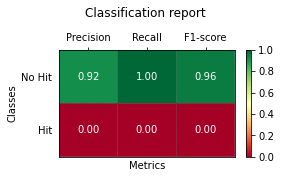

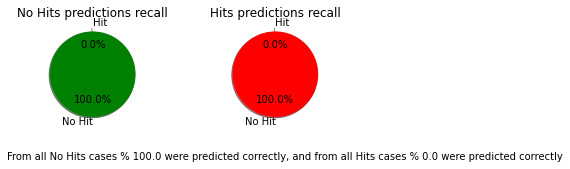

Cohen's kappa coefficient is same as the baseline:  0.0

Total Accuracy percentaje is same as the baseline: % 92.31

Hit Precision is same as the baseline:  0.0

Hit Recall is same as the baseline:  0.0

No Hit Precision is same as the baseline:  0.92

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit
True             
No Hit      16800
Yes Hit      1400



In [5]:
# zero rule algorithm for classification
def zero_rule_algorithm_fit(train, test):
    #DO NOTHING
    pass

def zero_rule_algorithm_classification(test):
    prediction = 0
    predicted = [prediction for i in range(len(test))]
    return predicted

repite_model_predict_algorithm(zero_rule_algorithm_fit, zero_rule_algorithm_classification, 100, 0.4)

## Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.13
Cohen's kappa coefficient: 0.37


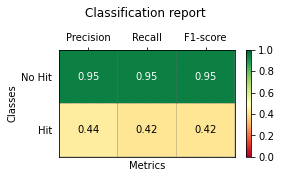

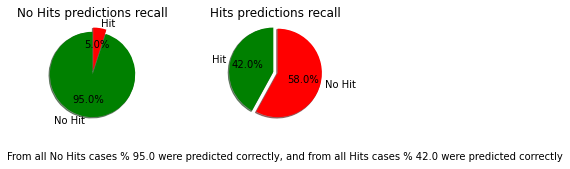

Cohen's kappa coefficient is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.18</span> below the baseline.

Hit Precision is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.42</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     160014     7986
Yes Hit      8155     5845



In [6]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

As we can see we have a good 'Total Accuracy' of 92 % and a good recall for false cases. The problem here is that it seems to be an overfitting given that the algorithm assert with almost the 96% false cases but when it is a true case we have around 48%. 

I decided to add two pie plots only to visualize the recall of both decisions, and in particular to show falses negatives percentage. In a real case we would try to avoid those negatives cases in order to avoid when the model predict that it will not be collision but it finally happens.

Regarding that, we can consider that the fact of having less true cases for training the model may be a problem for this investigation. However, we will try to see different approachs with the same data to deal with that.

As we can see in the Confusion Matrix we have almost 15 k true cases and we only predict almost 7k correctly.

Also this problem is repeated with 0.1, 0.2, 0.3 and 0.5 test_size.

## KNN classifier

### Search for best n neighbors number

In [5]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 10)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 4}

### KNN classifier with n=4

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.57
Cohen's kappa coefficient: -0.00


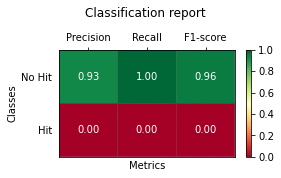

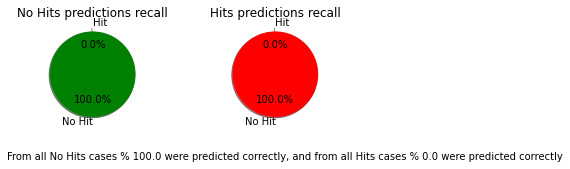

Cohen's kappa coefficient is same as the baseline:  -0.0

Total Accuracy percentaje is <span style="color:green">% +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is same as the baseline:  0.0

Hit Recall is same as the baseline:  0.0

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126821      179
Yes Hit     10000        0



In [13]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.3)

This case is a clear example of overfitting. We have a huge percentage of correct 'No Hit Predictions' but the opposite with 'Hit predictions'. The model seems to be used to predict that the driver it's not going to crash which translates into a high percentage of false negatives cases.

I used 20% of data set for testing, because performs better in this case.

## Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %94.44
Cohen's kappa coefficient: 0.44


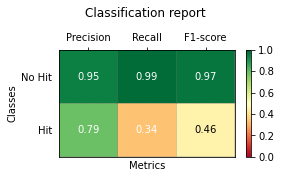

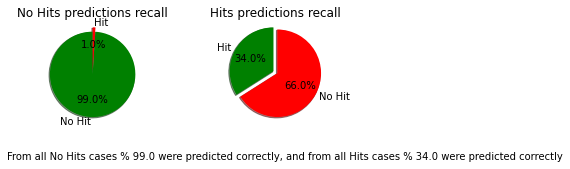

Cohen's kappa coefficient is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +2.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.79</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     125958     1042
Yes Hit      6579     3421



In [9]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

The same problem can be seen with this model, the best recall achieved was %30 trying with different training sizes.

# Over sampling data

Now we will try increasing the numbers of true cases with different over sampling approachs:

## Random Over Sampler

In [6]:
from imblearn.over_sampling import RandomOverSampler

def random_over_sampler_split(test_size):
    ros = RandomOverSampler()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    #X_resampled, y_resampled = X_train, y_train
    return X_resampled, X_test, y_resampled, y_test

def print_over_sampling_fuction(split_function, test_size):
    X_resampled, X_test, y_resampled, y_test = split_function(test_size)
    print_split_data_set(X_resampled, X_test, y_resampled, y_test)

In [7]:
def print_split_data_set(X_train, X_test, y_train, y_test):
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))
    
print_over_sampling_fuction(random_over_sampler_split, 0.4)

Training True  : 252 (50.00%)
Training False : 252 (50.00%)

Test True      : 14 (7.69%)
Test False     : 168 (92.31%)


Here we can see that False cases were splitted normally and "Training True" cases are now equals to falses.

### Decision Tree

This algorith was ignore because results were worst than before (without over sampling data)

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.46
Cohen's kappa coefficient: 0.04


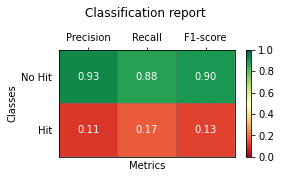

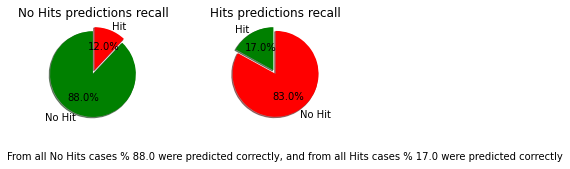

Cohen's kappa coefficient is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.85</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     147650    20350
Yes Hit     11565     2435



In [16]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, random_over_sampler_split)

With over sampling Knn seems to be better at recall, but it lose a lot of precision comparing without over sampling data.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %94.72
Cohen's kappa coefficient: 0.46


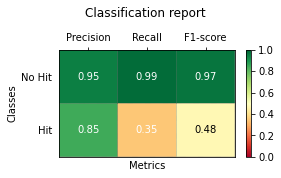

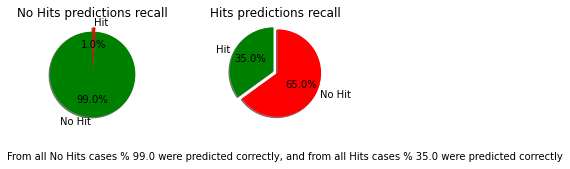

Cohen's kappa coefficient is <span style="color:green"> +0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +2.41</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.85</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      63143      357
Yes Hit      3262     1738



In [17]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3, random_over_sampler_split)

For random forest there is no difference with random over sampling data.

## SMOTE

In [10]:
from imblearn.over_sampling import SMOTE, ADASYN

def smote_over_sampler_split(test_size):
    smote = SMOTE()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = smote.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(smote_over_sampler_split, 0.4)

Training True  : 252 (50.00%)
Training False : 252 (50.00%)

Test True      : 14 (7.69%)
Test False     : 168 (92.31%)


### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.56
Cohen's kappa coefficient: 0.25


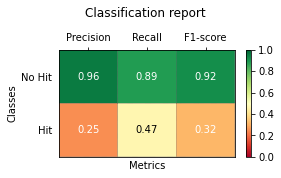

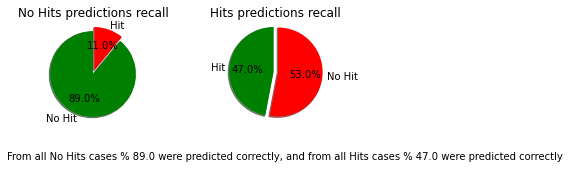

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.75</span> below the baseline.

Hit Precision is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.47</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     112498    14502
Yes Hit      5283     4717



In [19]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.3, smote_over_sampler_split)

Decision Tree doesn't change results with over sampling data.

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %62.35
Cohen's kappa coefficient: 0.03


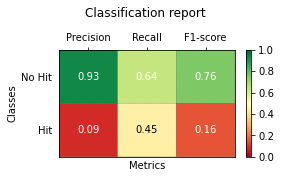

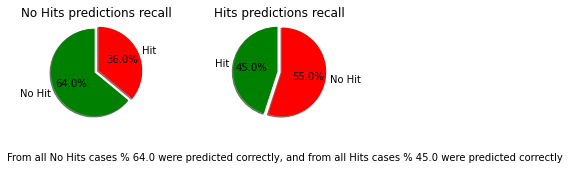

Cohen's kappa coefficient is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -29.96</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.45</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.36</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      53564    30436
Yes Hit      3824     3176



In [20]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, smote_over_sampler_split)

With Smote we have better Recall but worst precision.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.88
Cohen's kappa coefficient: 0.36


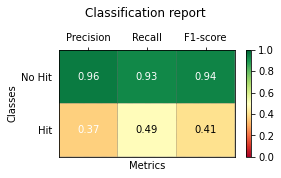

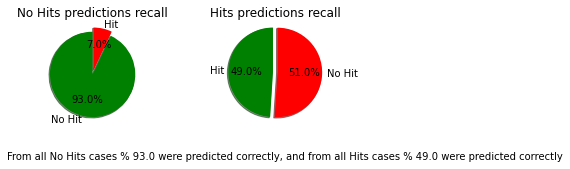

Cohen's kappa coefficient is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.43</span> below the baseline.

Hit Precision is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.49</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      59118     4382
Yes Hit      2552     2448



In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3, smote_over_sampler_split)

This are similars results as Randon Forest without over sampling, but with a considerable worst precision. It is still possible to notice the overfitting.

## ADASYN

In [12]:
def adasyn_over_sampler_split(test_size):
    adasyn = ADASYN()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = adasyn.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(adasyn_over_sampler_split, 0.4)

Training True  : 248 (49.60%)
Training False : 252 (50.40%)

Test True      : 14 (7.69%)
Test False     : 168 (92.31%)


This oversampling it's not totally exactly when doing the true training cases. So it's not exactly 50% of each.

### Decision Tree

Ignored

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %60.81
Cohen's kappa coefficient: 0.03


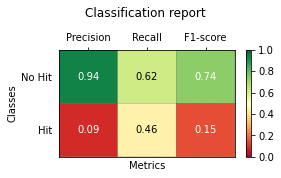

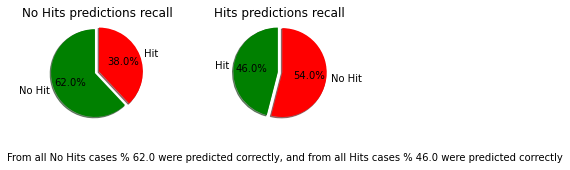

Cohen's kappa coefficient is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -31.5</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.46</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.38</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      78695    48305
Yes Hit      5389     4611



In [20]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.3, adasyn_over_sampler_split)

Similar recall to Smote but worst precision.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.87
Cohen's kappa coefficient: 0.37


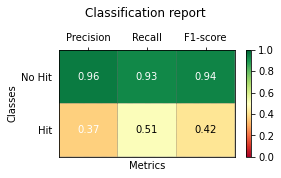

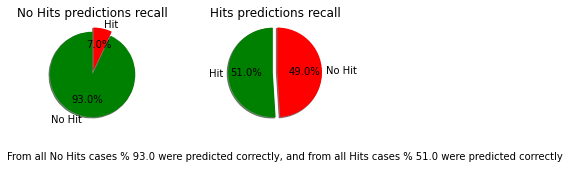

Cohen's kappa coefficient is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.44</span> below the baseline.

Hit Precision is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.51</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     118061     8939
Yes Hit      4941     5059



In [24]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, adasyn_over_sampler_split)

Worst results than smote and no over sampling.

# Changing training data

I will try training the data with the same numbers of false cases and true cases but this time with less false cases:

In [15]:
def equal_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives)

def double_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*2)

size = 3
def global_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*size)

def split_cases(positive_training_size, negative_training_size):
    positives = data.loc[df['hadCollision'] == 1].copy()
    negatives = data.loc[df['hadCollision'] == 0].copy()
    test_size_pos = len(positives) - positive_training_size
    test_size_neg = len(negatives) - negative_training_size

    X_train_pos, X_test_pos = train_test_split(positives, train_size=positive_training_size, test_size=test_size_pos)
    X_train_neg, X_test_neg = train_test_split(negatives, train_size=negative_training_size, test_size=test_size_neg)
    X_train_total = X_train_pos.append(X_train_neg)
    X_test_total = X_test_pos.append(X_test_neg)

    X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
    X_test_total = X_test_total.sample(frac=1).reset_index(drop=True)
    X_train = X_train_total.drop('hadCollision', axis=1) 
    y_train = X_train_total['hadCollision']

    X_test = X_test_total.drop('hadCollision', axis=1) 
    y_test = X_test_total['hadCollision']
    return X_train, X_test, y_train, y_test

def print_results_with_size(split_function, train_size_pos):
    X_train, X_test, y_train, y_test = split_function(train_size_pos)
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

In [16]:
print_results_with_size(equal_cases_split, 28)

Training True  : 28 (50.00%)
Training False : 28 (50.00%)

Test True      : 6 (1.51%)
Test False     : 392 (98.49%)


We have now a training set of only 60 cases with 50% hits and 50% no hits. I decided to take 30 true cases as it's almost de 80% of true cases for training.

### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %72.35
Cohen's kappa coefficient: 0.06


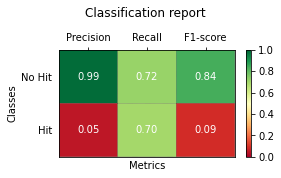

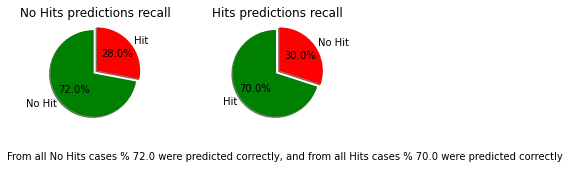

Cohen's kappa coefficient is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -19.96</span> below the baseline.

Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.28</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     285272   108728
Yes Hit      2413     5587



In [36]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 26, equal_cases_split)

The recall is strongly increased with this approach, but now the "No hit" predictions are not as good as before and that makes a presicion for "Yes Hit"'s cases really bad due to compare 5k correct predictions with more than 100k false positives.

In [28]:
size = 4
print_results_with_size(global_false_cases_split, 20)

Training True  : 20 (20.00%)
Training False : 80 (80.00%)

Test True      : 14 (3.95%)
Test False     : 340 (96.05%)


Trying with the double of false cases for training in order to get more precision of "Yes Hit" cases, but this time taking only 20 true cases for training.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.90
Cohen's kappa coefficient: 0.10


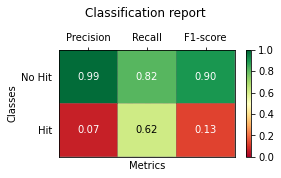

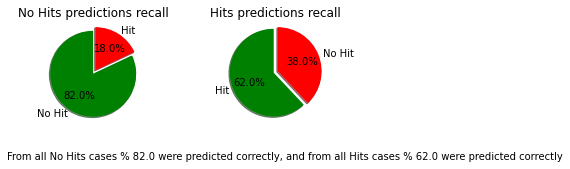

Cohen's kappa coefficient is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.41</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.62</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     302993    65007
Yes Hit      3049     4951



In [35]:
clf = tree.DecisionTreeClassifier()
size = 2
repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 26, global_false_cases_split)

We could increase the recall of "No Hit", which affects to "Yes Hit" precision on almost the triple, but is still low. 

### Knn

<h3>Multiple experiments average result:</h3>

Total Accuracy: %55.96
Cohen's kappa coefficient: 0.00


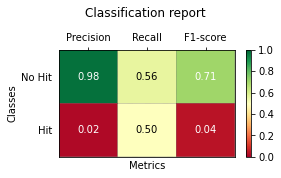

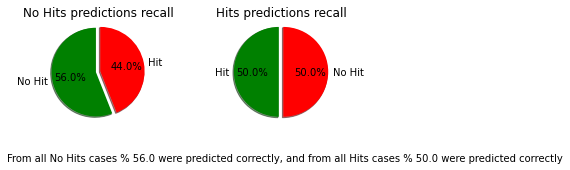

Cohen's kappa coefficient is same as the baseline:  0.0

Total Accuracy percentaje is <span style="color:red">% -36.35</span> below the baseline.

Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.5</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.44</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     220997   173003
Yes Hit      4028     3972



In [17]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  26, equal_cases_split)

Worst metrics as before

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.39
Cohen's kappa coefficient: 0.01


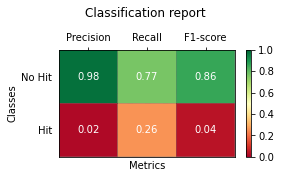

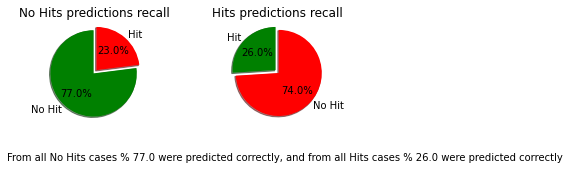

Cohen's kappa coefficient is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.92</span> below the baseline.

Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     285171    82829
Yes Hit      5943     2057



In [18]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  26, double_false_cases_split)

We recorver the recall of "No Hits" predictions but it's not enougth to have good precision of "Yes Hit"

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.32
Cohen's kappa coefficient: 0.10


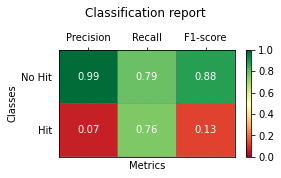

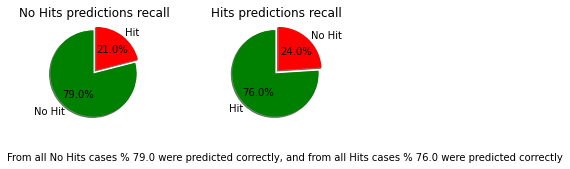

Cohen's kappa coefficient is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.99</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     156388    40612
Yes Hit       948     3052



In [39]:
rf_model = RandomForestClassifier()

repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 26, equal_cases_split)

The recall it's considerable better with this configuration. However the model now seems to see a lot of cases positives than before. This doesn't affect "No hit" precision or recall, but the precision of "Yes Hit" cases it's considerable worst than before. This means we have now a lot of False Positive cases.

We can see in the confusion matrix that almost 72k cases were predicted with a collision and there were false hits. In real life this will be a problem because we would be alerting for nothing really, but in fact it is not as important as the opposite case.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.02
Cohen's kappa coefficient: 0.20


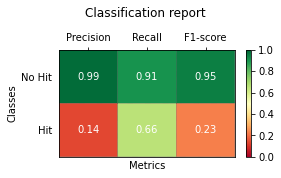

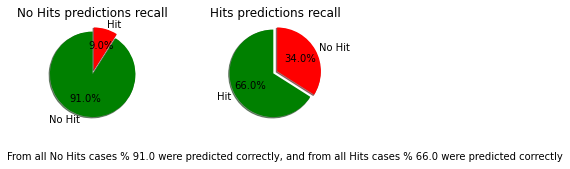

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.29</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     166601    17399
Yes Hit      1355     2645



In [40]:
rf_model = RandomForestClassifier()
size = 2
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 26, global_false_cases_split)

There is an improvement with the precision of "Yes Hit" but still low. On the other hand, the recall of "Yes Hit" it's not as good as before, but in the combination of both (f1-score) this is a better configuration.

The preference on the result will depend on the weigth of those classes.

# Weights classes

## Balanced

### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.45
Cohen's kappa coefficient: 0.29


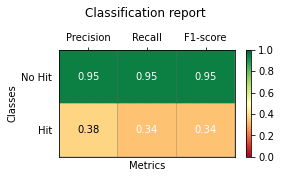

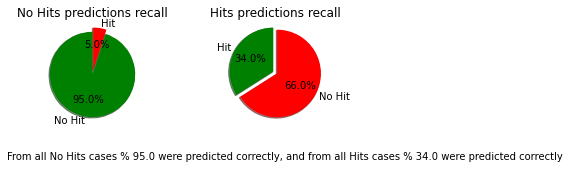

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.86</span> below the baseline.

Hit Precision is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      39971     2029
Yes Hit      2314     1186



In [42]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')

repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.67
Cohen's kappa coefficient: 0.31


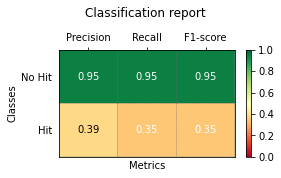

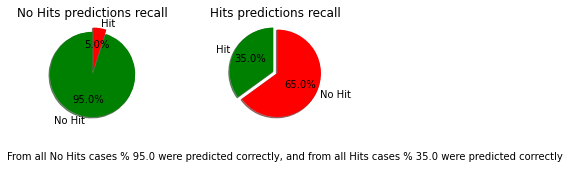

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.64</span> below the baseline.

Hit Precision is <span style="color:green"> +0.39</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      80076     3924
Yes Hit      4566     2434



In [43]:
clf = tree.DecisionTreeClassifier(class_weight={0:1, 1:9})

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.24
Cohen's kappa coefficient: 0.41


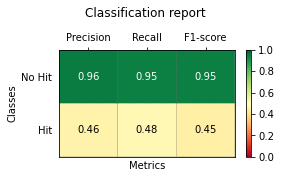

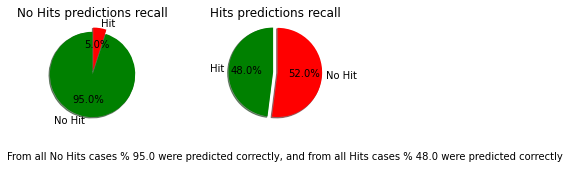

Cohen's kappa coefficient is <span style="color:green"> +0.41</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.07</span> below the baseline.

Hit Precision is <span style="color:green"> +0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.48</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      79660     4340
Yes Hit      3629     3371



In [44]:
clf = tree.DecisionTreeClassifier(class_weight={0:9, 1:1})

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

Worst than default case.

### KNN

Default value is 'uniform' or balance, so I will try with distance

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.64
Cohen's kappa coefficient: 0.00


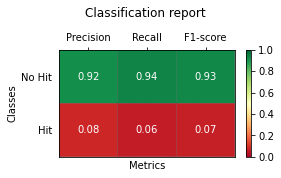

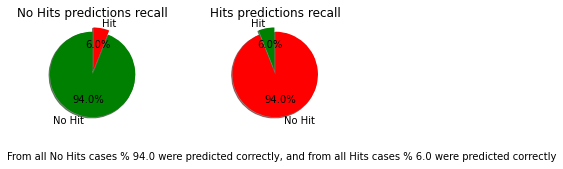

Cohen's kappa coefficient is same as the baseline:  0.0

Total Accuracy percentaje is <span style="color:red">% -4.67</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is same as the baseline:  0.92

No Hit Recall is <span style="color:red"> -0.06</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      79341     4659
Yes Hit      6587      413



In [45]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  0.2)

Same overfitting as default case

### Random Forest

#### Balanced

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.81
Cohen's kappa coefficient: 0.24


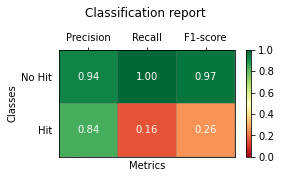

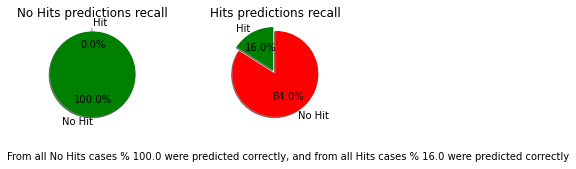

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.5</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.84</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      63480       20
Yes Hit      4219      781



In [46]:
rf_model = RandomForestClassifier(class_weight="balanced")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.92
Cohen's kappa coefficient: 0.27


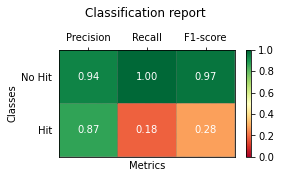

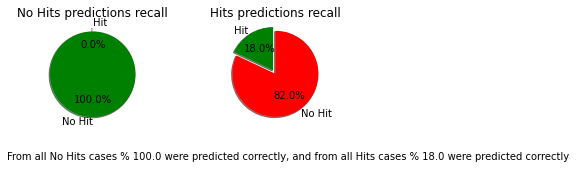

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.61</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.87</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      63461       39
Yes Hit      4124      876



In [47]:
rf_model = RandomForestClassifier(class_weight={0:1, 1:9})
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %94.14
Cohen's kappa coefficient: 0.46


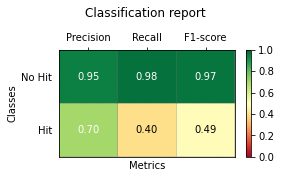

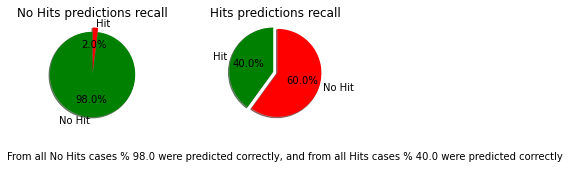

Cohen's kappa coefficient is <span style="color:green"> +0.46</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.83</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.4</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      62502      998
Yes Hit      3015     1985



In [48]:
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

Same overfitting as default.

#### Balanced Subsample

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.75
Cohen's kappa coefficient: 0.23


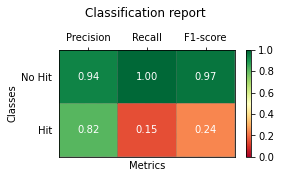

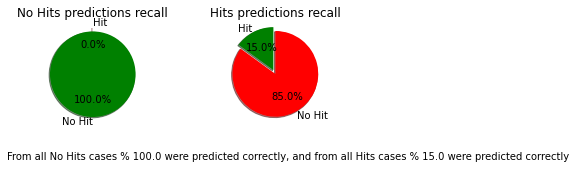

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.44</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.82</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126950       50
Yes Hit      8510     1490



In [49]:
rf_model = RandomForestClassifier(class_weight="balanced_subsample")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default

### Decision Tree

In [24]:
from IPython.core.display import display, Markdown

def print_header(header):
    raw_html = "<h3>"+header+"</h3>"
    display( Markdown(raw_html) )

<h3>Running: Default model-prediction</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.22
Cohen's kappa coefficient: 0.39


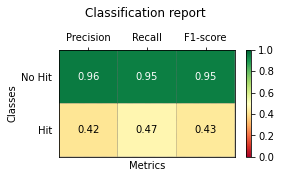

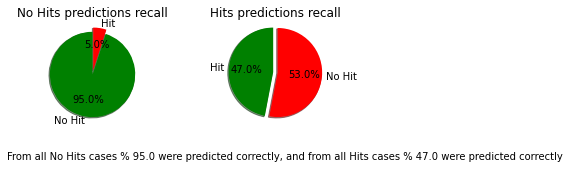

Cohen's kappa coefficient is <span style="color:green"> +0.39</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.09</span> below the baseline.

Hit Precision is <span style="color:green"> +0.42</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.47</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      60136     3364
Yes Hit      2652     2348



<h3>Running: Random Over Sampler</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.19
Cohen's kappa coefficient: 0.38


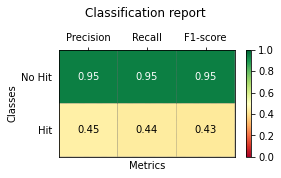

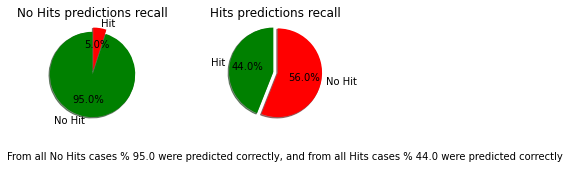

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.12</span> below the baseline.

Hit Precision is <span style="color:green"> +0.45</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      39957     2043
Yes Hit      1964     1536



<h3>Running: SMOTE</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.84
Cohen's kappa coefficient: 0.31


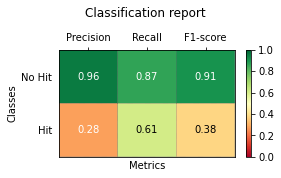

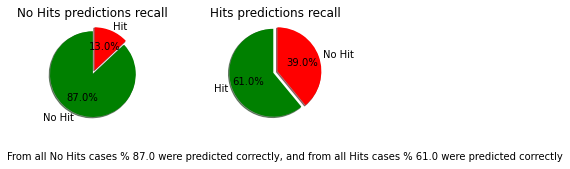

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.47</span> below the baseline.

Hit Precision is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.61</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      36478     5522
Yes Hit      1378     2122



<h3>Running: ADASYN</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.69
Cohen's kappa coefficient: 0.31


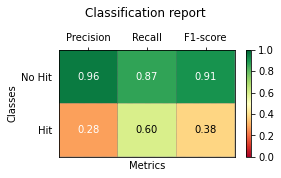

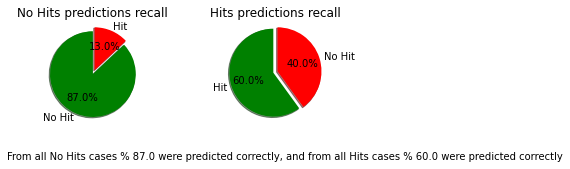

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.62</span> below the baseline.

Hit Precision is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.6</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      36430     5570
Yes Hit      1394     2106



<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %71.34
Cohen's kappa coefficient: 0.10


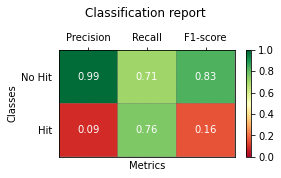

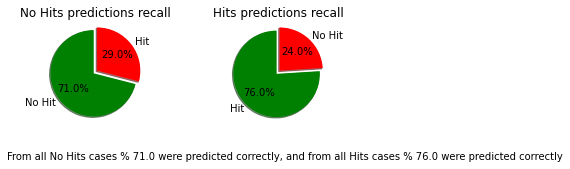

Cohen's kappa coefficient is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -20.97</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.29</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142330    57670
Yes Hit      1659     5341



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.45
Cohen's kappa coefficient: 0.16


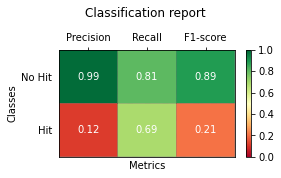

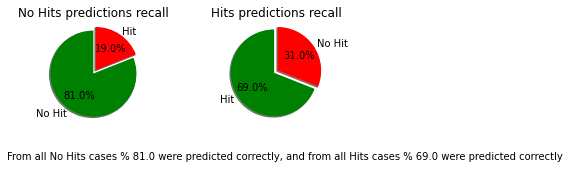

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.86</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     153639    36361
Yes Hit      2147     4853



<h3>Running: Triple false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.35
Cohen's kappa coefficient: 0.16


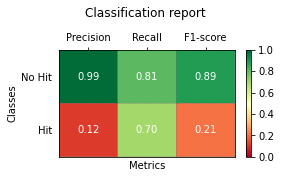

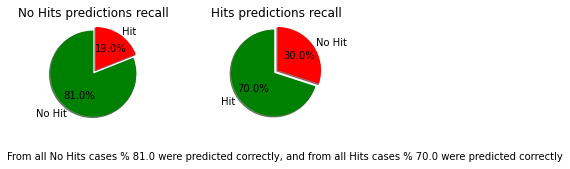

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.96</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     153358    36642
Yes Hit      2075     4925



In [51]:
def run_all_models(clf):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.3)

    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2, adasyn_over_sampler_split)

    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 20, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 20, double_false_cases_split)
    
    print_header("Running: Triple false training cases")
    size = 3
    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 20, global_false_cases_split)
    
clf = tree.DecisionTreeClassifier(class_weight={0:10, 1:1})
run_all_models(clf)

Regarding Hits predictions recall we can see a really good performance with "Equal training cases" but again still a bad precision for this class. 

Regarding F1-score, it means seen precision and recall, we acceptable performances with Smote and Random over samplers, and with default case we have a similar performance in each component.

### Knn

I didn't find Knn class_weigths, it has a function weigth but I think is only weigths per feature:
    
    - [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

### Random Forest

<h3>Running: Default model-prediction</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %94.11
Cohen's kappa coefficient: 0.45


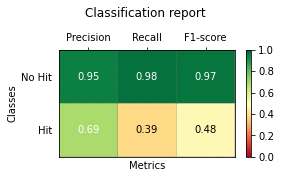

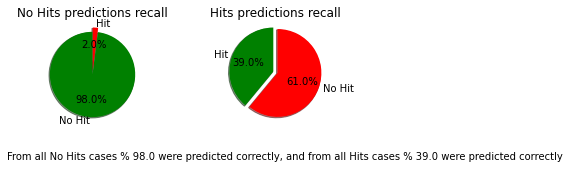

Cohen's kappa coefficient is <span style="color:green"> +0.45</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.8</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.39</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      62509      991
Yes Hit      3047     1953



<h3>Running: Random Over Sampler</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %94.09
Cohen's kappa coefficient: 0.52


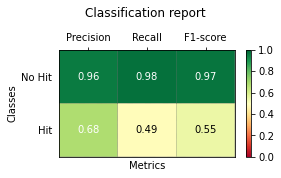

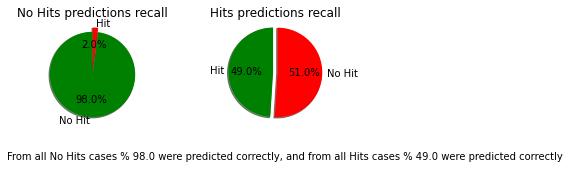

Cohen's kappa coefficient is <span style="color:green"> +0.52</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.78</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.49</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      41083      917
Yes Hit      1771     1729



<h3>Running: SMOTE</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.99
Cohen's kappa coefficient: 0.40


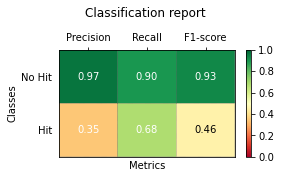

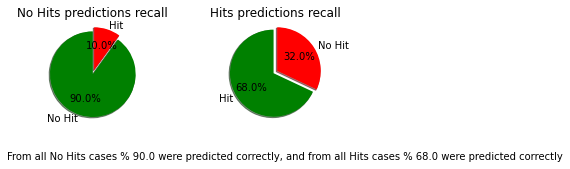

Cohen's kappa coefficient is <span style="color:green"> +0.4</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.32</span> below the baseline.

Hit Precision is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      56871     6629
Yes Hit      1598     3402



<h3>Running: ADASYN</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.21
Cohen's kappa coefficient: 0.41


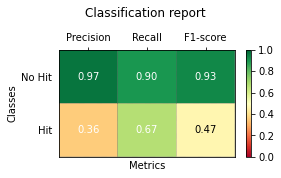

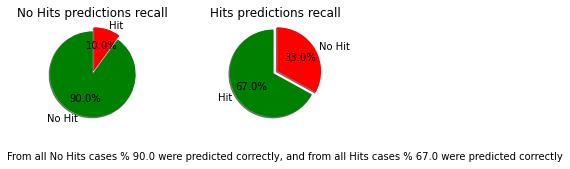

Cohen's kappa coefficient is <span style="color:green"> +0.41</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.1</span> below the baseline.

Hit Precision is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      75569     8431
Yes Hit      2302     4698



<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %75.65
Cohen's kappa coefficient: 0.13


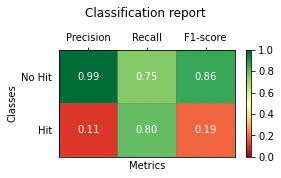

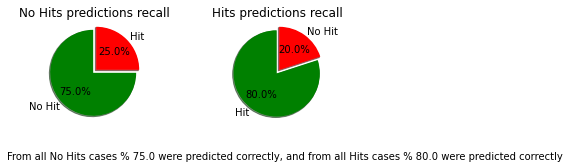

Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -16.66</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.25</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     150993    49007
Yes Hit      1388     5612



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.53
Cohen's kappa coefficient: 0.23


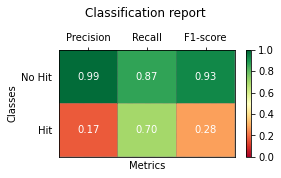

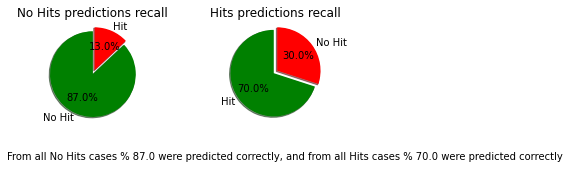

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.78</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     165565    24435
Yes Hit      2099     4901



<h3>Running: Triple false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.51
Cohen's kappa coefficient: 0.23


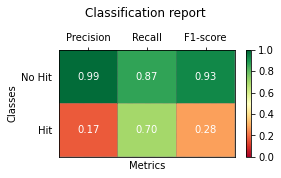

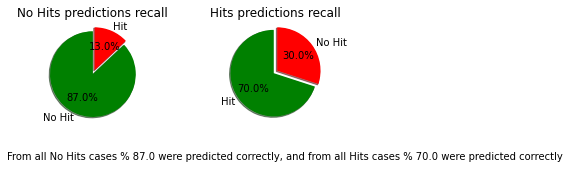

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.8</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     165501    24499
Yes Hit      2071     4929



In [52]:
def run_all_models(rf_model):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)
    
    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.4, adasyn_over_sampler_split)
    
    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 20, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 20, double_false_cases_split)
    
    print_header("Running: Triple false training cases")
    size = 3
    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 20, global_false_cases_split)
    
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
run_all_models(rf_model)

We can see again very good recalls for Hits predictions in Equal and Double False training cases. However regarding both variables Precision and Recall, the best prediction seems to be with SMOTE over sampling having acceptables metrics in both.

<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.22
Cohen's kappa coefficient: 0.08


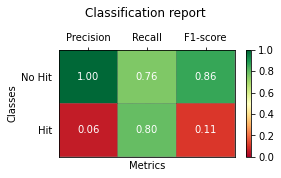

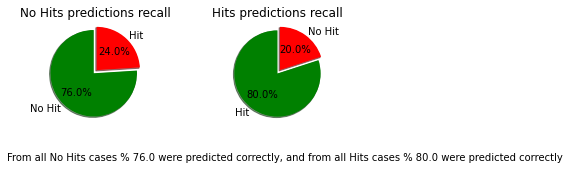

Cohen's kappa coefficient is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -16.09</span> below the baseline.

Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.24</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     149615    46885
Yes Hit       684     2816



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.29
Cohen's kappa coefficient: 0.15


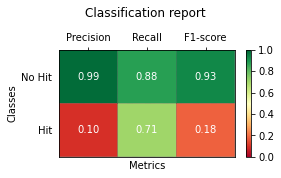

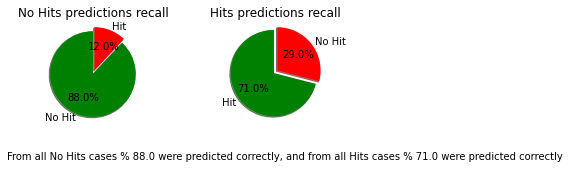

Cohen's kappa coefficient is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.02</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     160307    22693
Yes Hit      1017     2483



<h3>Running: Triple false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %91.06
Cohen's kappa coefficient: 0.21


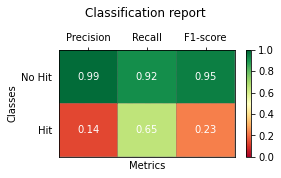

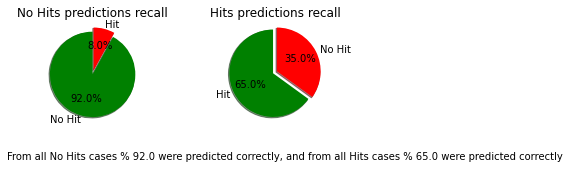

Cohen's kappa coefficient is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.25</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.08</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     155277    14223
Yes Hit      1240     2260



In [26]:
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

print_header("Running: Equal training cases")

repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 27, equal_cases_split)

print_header("Running: Double false training cases")

repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 27, double_false_cases_split)

print_header("Running: Triple false training cases")
size = 3
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 27, global_false_cases_split)

## Combine split and oversampling

In [22]:
resampler = SMOTE()
size = 2

def resampler_with_split_cases(training_size_positives):

    X_train, X_test, y_train, y_test = global_false_cases_split(training_size_positives)
    X_resampled, y_resampled = resampler.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_results_with_size(resampler_with_split_cases, 27)

Training True  : 54 (50.00%)
Training False : 54 (50.00%)

Test True      : 7 (1.88%)
Test False     : 366 (98.12%)


<h3>Running: SMOTE splitting in size 2 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.56
Cohen's kappa coefficient: 0.17


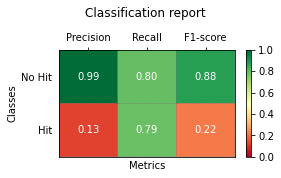

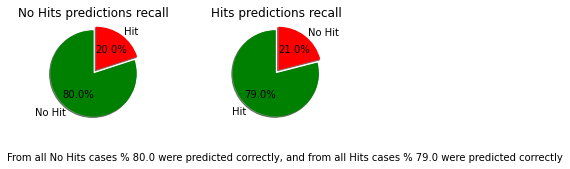

Cohen's kappa coefficient is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.75</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.79</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     151182    38818
Yes Hit      1447     5553



<h3>Running: SMOTE splitting in size 3 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.89
Cohen's kappa coefficient: 0.19


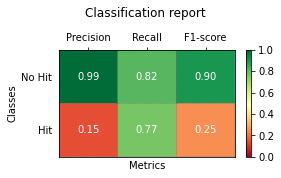

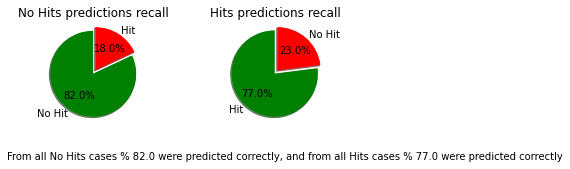

Cohen's kappa coefficient is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.42</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     147711    32289
Yes Hit      1580     5420



<h3>Running: SMOTE splitting in size 4 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.38
Cohen's kappa coefficient: 0.22


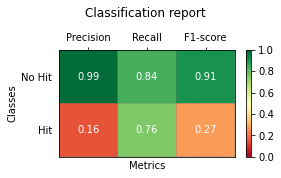

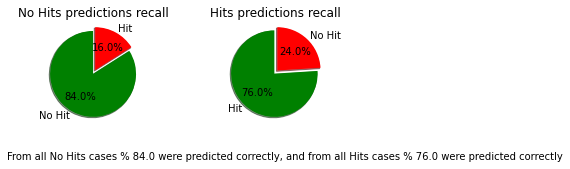

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.93</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142246    27754
Yes Hit      1660     5340



<h3>Running: SMOTE splitting in size 5 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.41
Cohen's kappa coefficient: 0.24


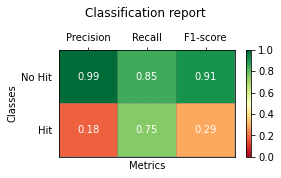

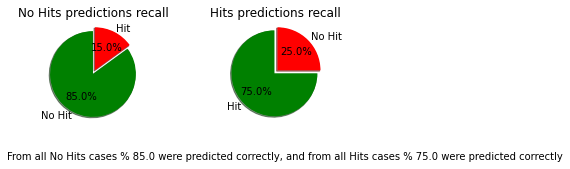

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.9</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135693    24307
Yes Hit      1728     5272



<h3>Running: SMOTE splitting in size 6 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.61
Cohen's kappa coefficient: 0.27


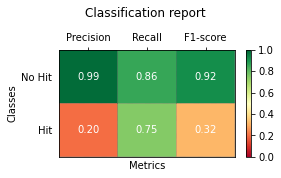

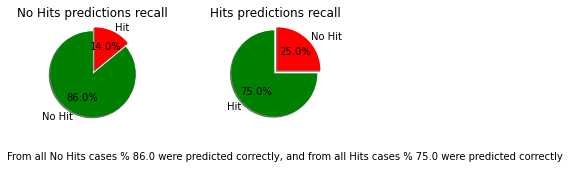

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.7</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     129184    20816
Yes Hit      1782     5218



<h3>Running: SMOTE splitting in size 7 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.38
Cohen's kappa coefficient: 0.29


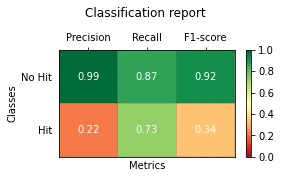

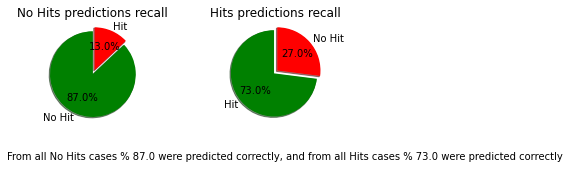

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.93</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     121838    18162
Yes Hit      1861     5139



<h3>Running: SMOTE splitting in size 8 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.88
Cohen's kappa coefficient: 0.31


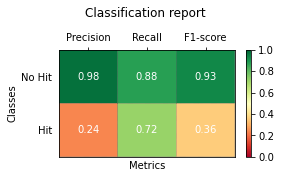

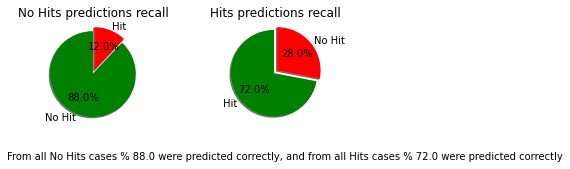

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.43</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     113995    16005
Yes Hit      1974     5026



<h3>Running: SMOTE splitting in size 9 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.45
Cohen's kappa coefficient: 0.34


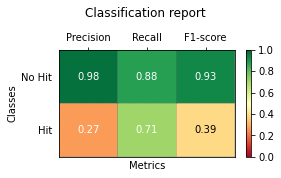

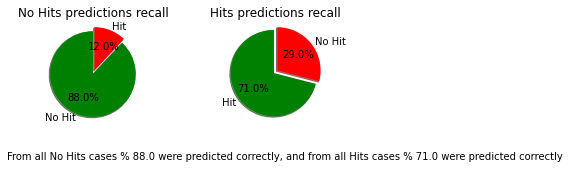

Cohen's kappa coefficient is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.86</span> below the baseline.

Hit Precision is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     106059    13941
Yes Hit      1995     5005



<h3>Running: SMOTE splitting in size 10 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.58
Cohen's kappa coefficient: 0.35


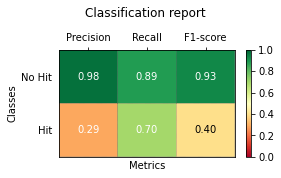

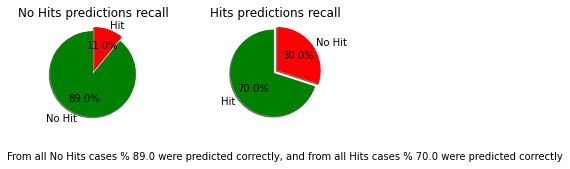

Cohen's kappa coefficient is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.73</span> below the baseline.

Hit Precision is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      97592    12408
Yes Hit      2127     4873



<h3>Running: SMOTE splitting in size 11 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.91
Cohen's kappa coefficient: 0.37


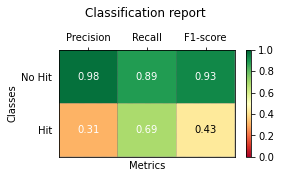

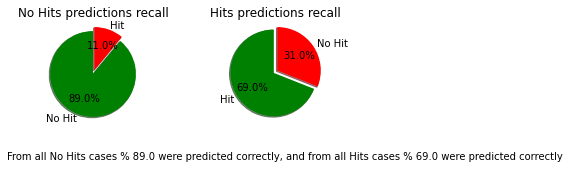

Cohen's kappa coefficient is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.4</span> below the baseline.

Hit Precision is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      89262    10738
Yes Hit      2195     4805



In [54]:
resampler = SMOTE()
positives = 20
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.21
Cohen's kappa coefficient: 0.17


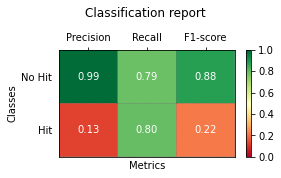

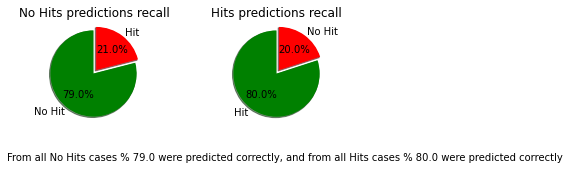

Cohen's kappa coefficient is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -13.1</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     150474    39526
Yes Hit      1422     5578



<h3>Running: ADASYN splitting in size 3 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.65
Cohen's kappa coefficient: 0.19


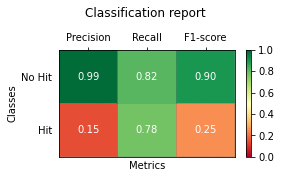

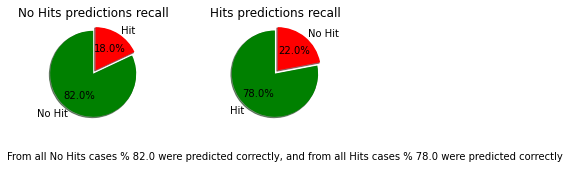

Cohen's kappa coefficient is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.66</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     147195    32805
Yes Hit      1518     5482



<h3>Running: ADASYN splitting in size 4 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.16
Cohen's kappa coefficient: 0.22


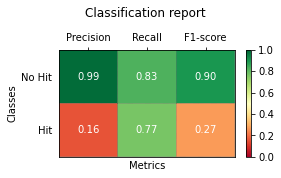

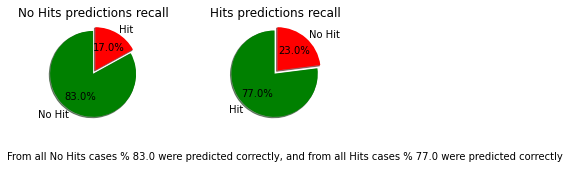

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.15</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     141829    28171
Yes Hit      1635     5365



<h3>Running: ADASYN splitting in size 5 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.50
Cohen's kappa coefficient: 0.24


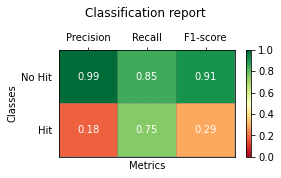

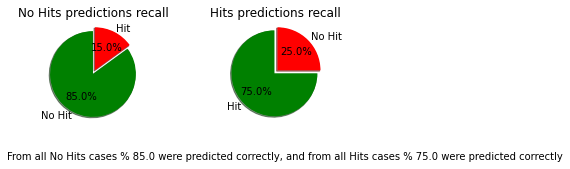

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.81</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135866    24134
Yes Hit      1754     5246



<h3>Running: ADASYN splitting in size 6 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.96
Cohen's kappa coefficient: 0.26


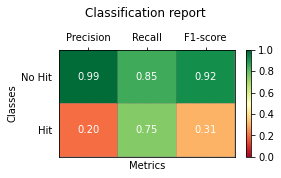

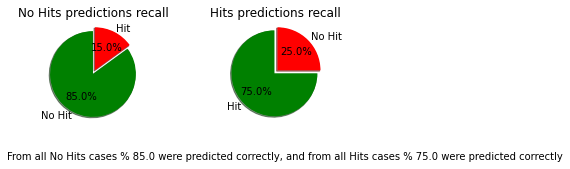

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.35</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     128132    21868
Yes Hit      1741     5259



<h3>Running: ADASYN splitting in size 7 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.06
Cohen's kappa coefficient: 0.28


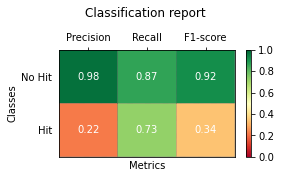

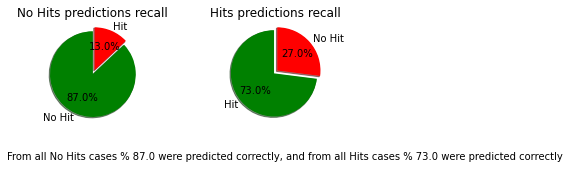

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.25</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     121392    18608
Yes Hit      1878     5122



<h3>Running: ADASYN splitting in size 8 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.57
Cohen's kappa coefficient: 0.30


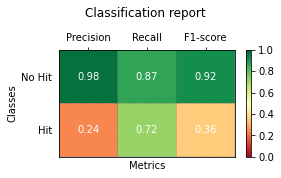

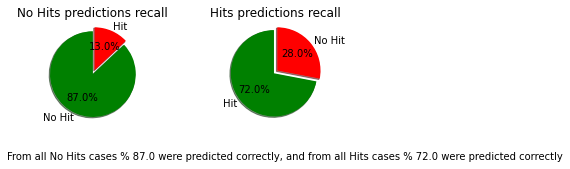

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.74</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     113531    16469
Yes Hit      1932     5068



<h3>Running: ADASYN splitting in size 9 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.33
Cohen's kappa coefficient: 0.33


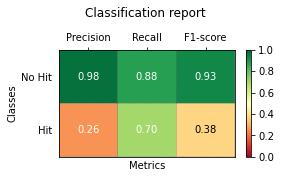

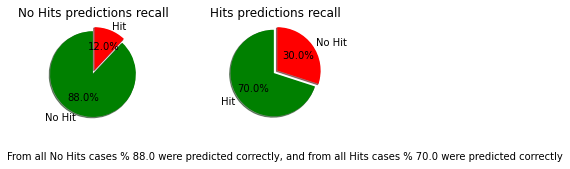

Cohen's kappa coefficient is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.98</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     106004    13996
Yes Hit      2096     4904



<h3>Running: ADASYN splitting in size 10 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.60
Cohen's kappa coefficient: 0.35


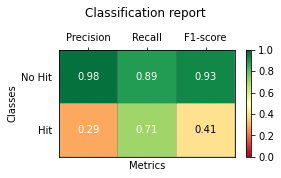

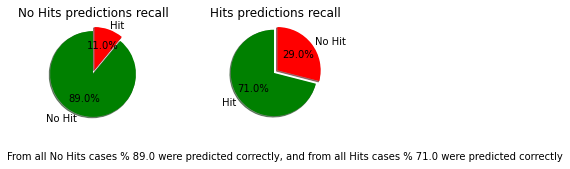

Cohen's kappa coefficient is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.71</span> below the baseline.

Hit Precision is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      97521    12479
Yes Hit      2028     4972



<h3>Running: ADASYN splitting in size 11 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.87
Cohen's kappa coefficient: 0.37


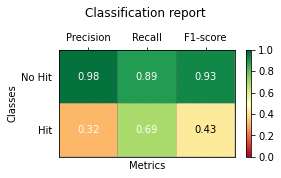

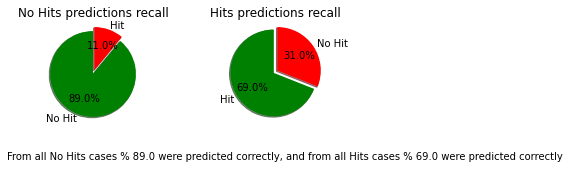

Cohen's kappa coefficient is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.44</span> below the baseline.

Hit Precision is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      89156    10844
Yes Hit      2140     4860



In [55]:
resampler = ADASYN()
positives = 20

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.85
Cohen's kappa coefficient: 0.13


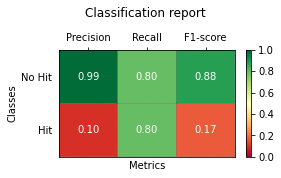

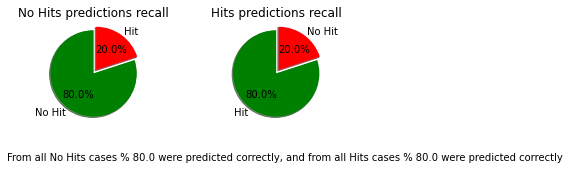

Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.46</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     148529    37471
Yes Hit      1024     3976



<h3>Running: SMOTE splitting in size 3 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.12
Cohen's kappa coefficient: 0.16


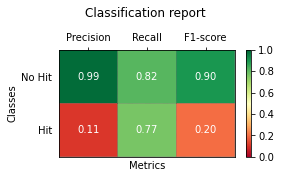

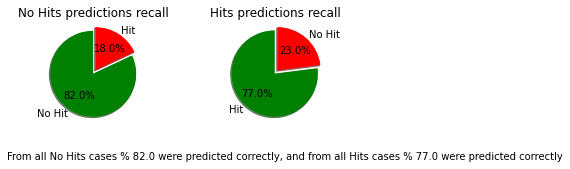

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.19</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     143125    30875
Yes Hit      1130     3870



<h3>Running: SMOTE splitting in size 4 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.70
Cohen's kappa coefficient: 0.18


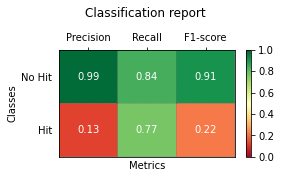

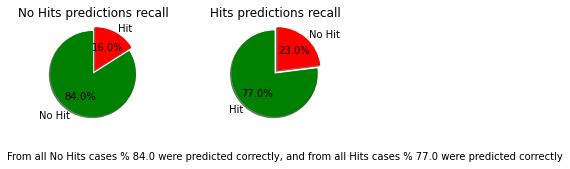

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.61</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135946    26054
Yes Hit      1160     3840



<h3>Running: SMOTE splitting in size 5 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.84
Cohen's kappa coefficient: 0.20


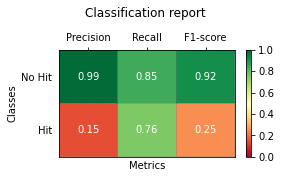

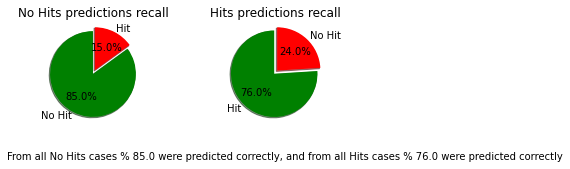

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.47</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     127710    22290
Yes Hit      1206     3794



<h3>Running: SMOTE splitting in size 6 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.65
Cohen's kappa coefficient: 0.22


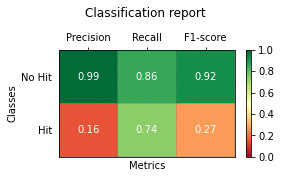

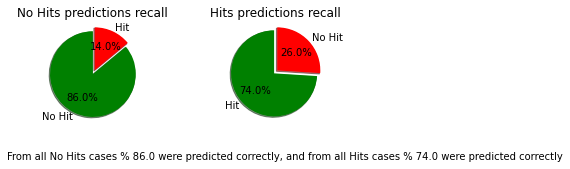

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.66</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     118775    19225
Yes Hit      1299     3701



<h3>Running: SMOTE splitting in size 7 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.35
Cohen's kappa coefficient: 0.24


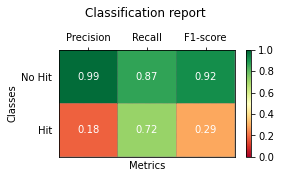

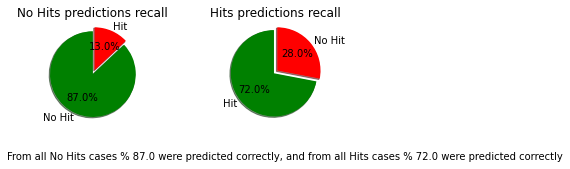

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.96</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     109489    16511
Yes Hit      1375     3625



<h3>Running: SMOTE splitting in size 8 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.92
Cohen's kappa coefficient: 0.27


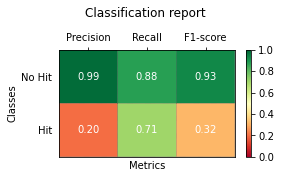

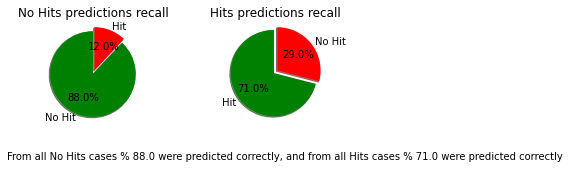

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.39</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      99864    14136
Yes Hit      1426     3574



<h3>Running: SMOTE splitting in size 9 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.60
Cohen's kappa coefficient: 0.30


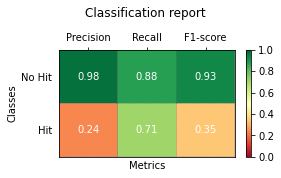

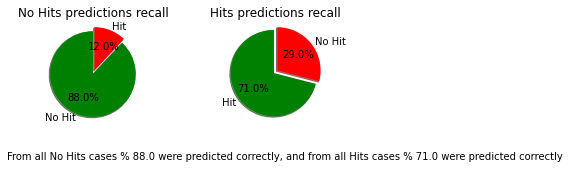

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.71</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      90181    11819
Yes Hit      1451     3549



<h3>Running: SMOTE splitting in size 10 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.59
Cohen's kappa coefficient: 0.32


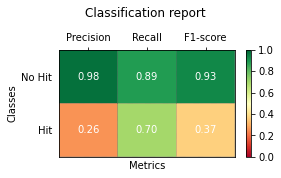

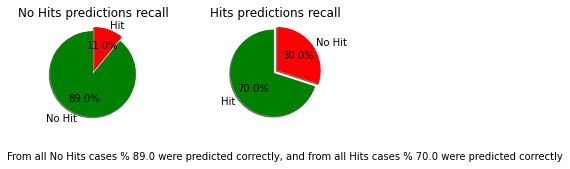

Cohen's kappa coefficient is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.72</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      79725    10275
Yes Hit      1518     3482



<h3>Running: SMOTE splitting in size 11 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.99
Cohen's kappa coefficient: 0.36


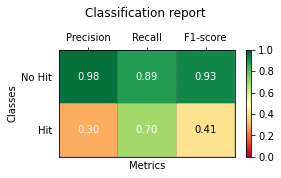

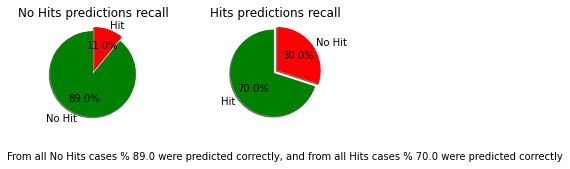

Cohen's kappa coefficient is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.32</span> below the baseline.

Hit Precision is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      69547     8453
Yes Hit      1518     3482



In [56]:
resampler = SMOTE()
positives = 24
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.65
Cohen's kappa coefficient: 0.13


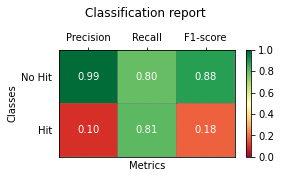

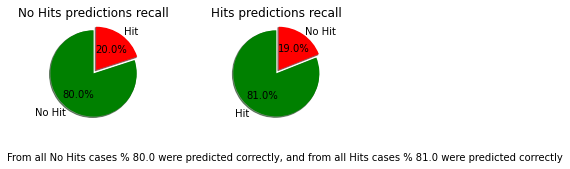

Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.66</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.81</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     148095    37905
Yes Hit       959     4041



<h3>Running: ADASYN splitting in size 3 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.56
Cohen's kappa coefficient: 0.15


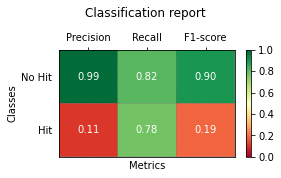

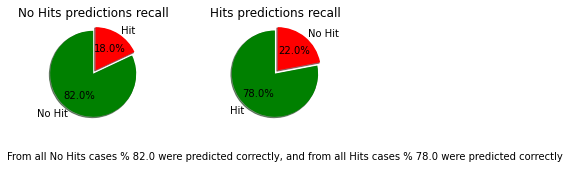

Cohen's kappa coefficient is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.75</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142104    31896
Yes Hit      1105     3895



<h3>Running: ADASYN splitting in size 4 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.13
Cohen's kappa coefficient: 0.18


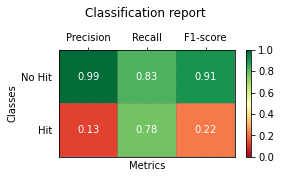

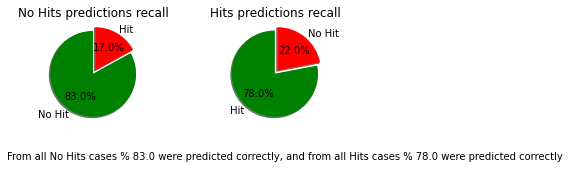

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.18</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134950    27050
Yes Hit      1119     3881



<h3>Running: ADASYN splitting in size 5 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.25
Cohen's kappa coefficient: 0.20


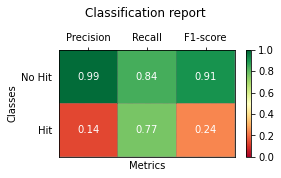

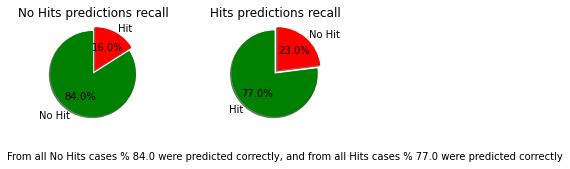

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.06</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126718    23282
Yes Hit      1135     3865



<h3>Running: ADASYN splitting in size 6 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.48
Cohen's kappa coefficient: 0.22


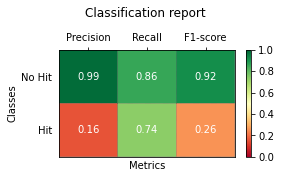

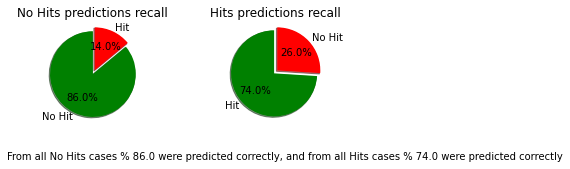

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.83</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     118544    19456
Yes Hit      1301     3699



<h3>Running: ADASYN splitting in size 7 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.81
Cohen's kappa coefficient: 0.24


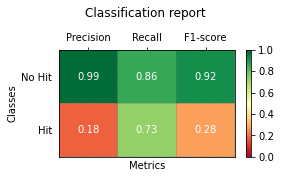

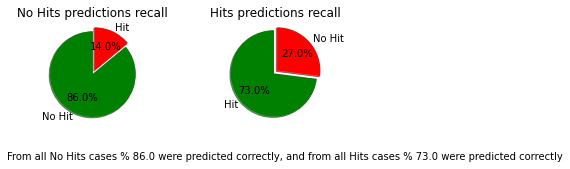

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.5</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     108758    17242
Yes Hit      1343     3657



<h3>Running: ADASYN splitting in size 8 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.83
Cohen's kappa coefficient: 0.27


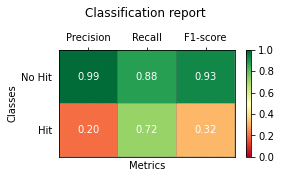

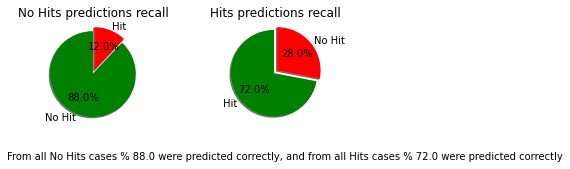

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.48</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      99753    14247
Yes Hit      1424     3576



<h3>Running: ADASYN splitting in size 9 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.15
Cohen's kappa coefficient: 0.29


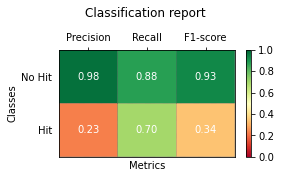

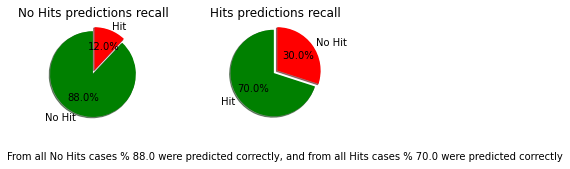

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.16</span> below the baseline.

Hit Precision is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      89744    12256
Yes Hit      1496     3504



<h3>Running: ADASYN splitting in size 10 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.64
Cohen's kappa coefficient: 0.33


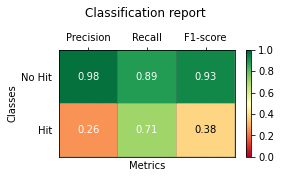

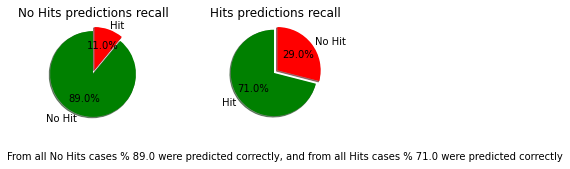

Cohen's kappa coefficient is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.67</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      79696    10304
Yes Hit      1438     3562



<h3>Running: ADASYN splitting in size 11 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.85
Cohen's kappa coefficient: 0.36


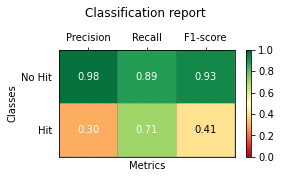

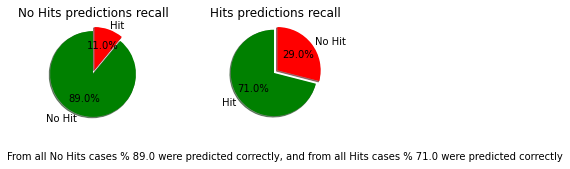

Cohen's kappa coefficient is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.46</span> below the baseline.

Hit Precision is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      69387     8613
Yes Hit      1469     3531



In [57]:
resampler = ADASYN()
positives = 24

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.70
Cohen's kappa coefficient: 0.20


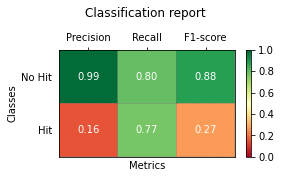

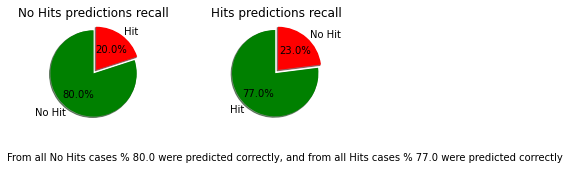

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.61</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     155673    39327
Yes Hit      2188     7312



<h3>Running: SMOTE splitting in size 3 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.55
Cohen's kappa coefficient: 0.23


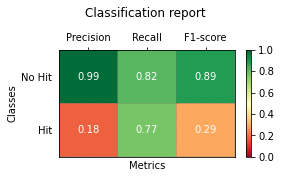

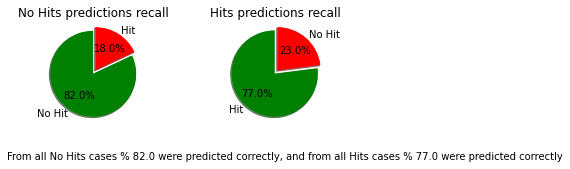

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.76</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     153329    34171
Yes Hit      2167     7333



<h3>Running: SMOTE splitting in size 4 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.12
Cohen's kappa coefficient: 0.25


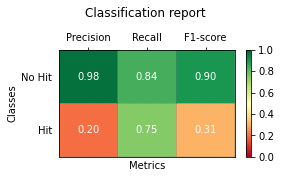

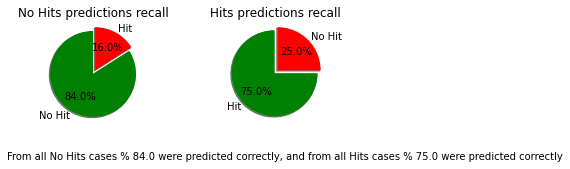

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.19</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     150340    29660
Yes Hit      2331     7169



<h3>Running: SMOTE splitting in size 5 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.30
Cohen's kappa coefficient: 0.28


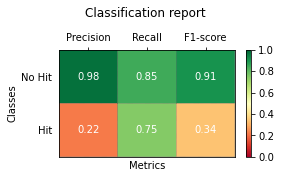

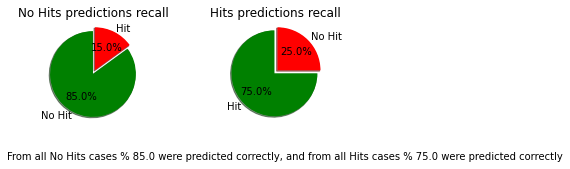

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.01</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     146321    26179
Yes Hit      2397     7103



<h3>Running: SMOTE splitting in size 6 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.44
Cohen's kappa coefficient: 0.30


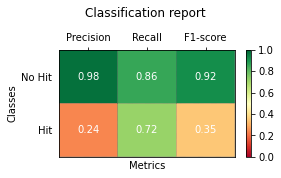

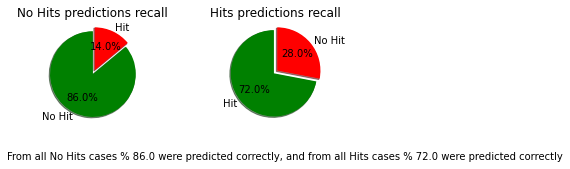

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.87</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142233    22767
Yes Hit      2636     6864



<h3>Running: SMOTE splitting in size 7 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.23
Cohen's kappa coefficient: 0.32


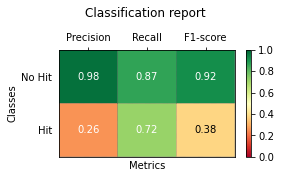

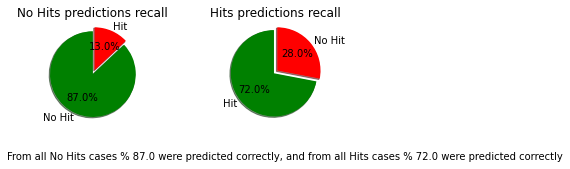

Cohen's kappa coefficient is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.08</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     137150    20350
Yes Hit      2645     6855



<h3>Running: SMOTE splitting in size 8 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.77
Cohen's kappa coefficient: 0.33


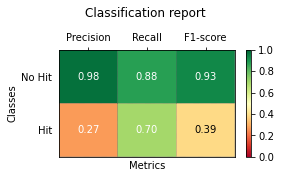

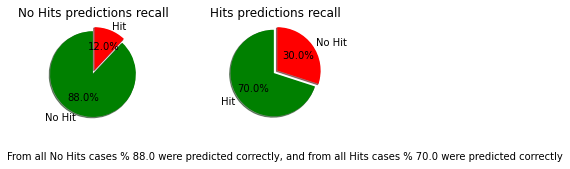

Cohen's kappa coefficient is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.54</span> below the baseline.

Hit Precision is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     131746    18254
Yes Hit      2842     6658



<h3>Running: SMOTE splitting in size 9 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.10
Cohen's kappa coefficient: 0.35


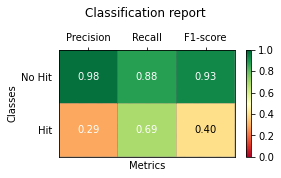

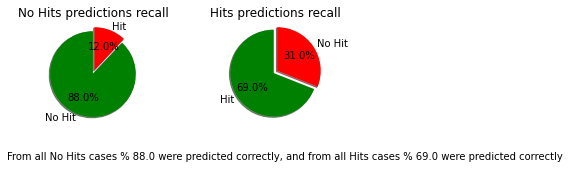

Cohen's kappa coefficient is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.21</span> below the baseline.

Hit Precision is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     125814    16686
Yes Hit      2927     6573



<h3>Running: SMOTE splitting in size 10 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.76
Cohen's kappa coefficient: 0.37


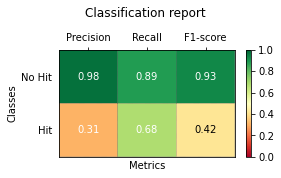

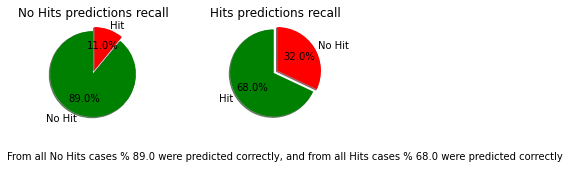

Cohen's kappa coefficient is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.55</span> below the baseline.

Hit Precision is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     120373    14627
Yes Hit      3065     6435



<h3>Running: SMOTE splitting in size 11 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.14
Cohen's kappa coefficient: 0.39


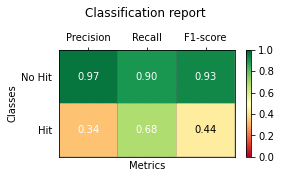

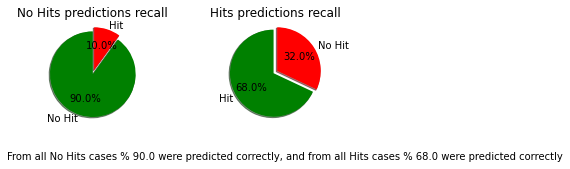

Cohen's kappa coefficient is <span style="color:green"> +0.39</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.17</span> below the baseline.

Hit Precision is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.1</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     114292    13208
Yes Hit      3047     6453



In [58]:
resampler = SMOTE()
positives = 15
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.40
Cohen's kappa coefficient: 0.20


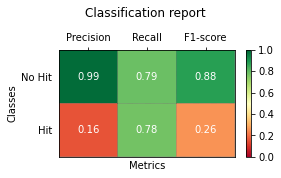

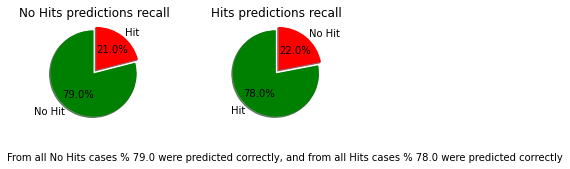

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.91</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     154954    40046
Yes Hit      2080     7420



<h3>Running: ADASYN splitting in size 3 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.25
Cohen's kappa coefficient: 0.23


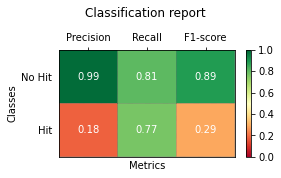

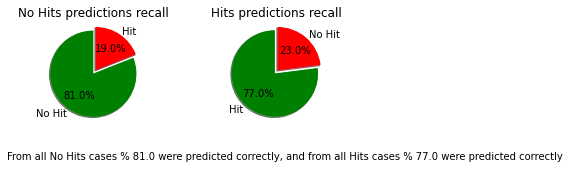

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.06</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     152709    34791
Yes Hit      2156     7344



<h3>Running: ADASYN splitting in size 4 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.71
Cohen's kappa coefficient: 0.25


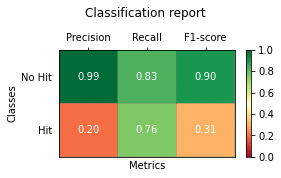

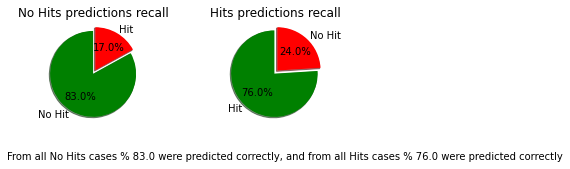

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.6</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     149511    30489
Yes Hit      2270     7230



<h3>Running: ADASYN splitting in size 5 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.02
Cohen's kappa coefficient: 0.27


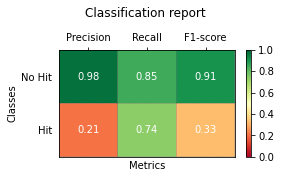

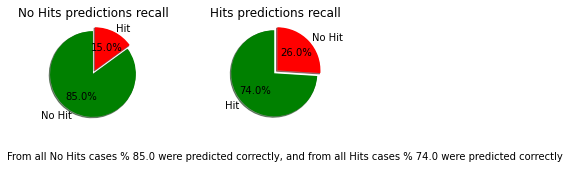

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.29</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145858    26642
Yes Hit      2437     7063



<h3>Running: ADASYN splitting in size 6 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.37
Cohen's kappa coefficient: 0.30


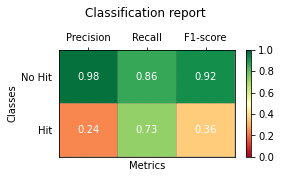

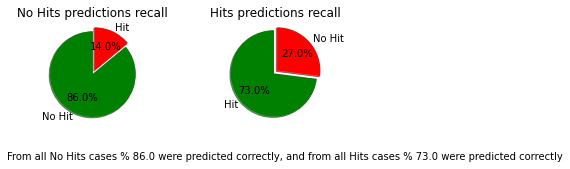

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.94</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     141993    23007
Yes Hit      2530     6970



<h3>Running: ADASYN splitting in size 7 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.09
Cohen's kappa coefficient: 0.31


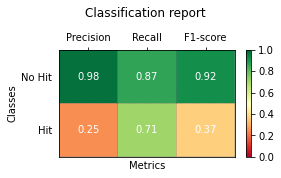

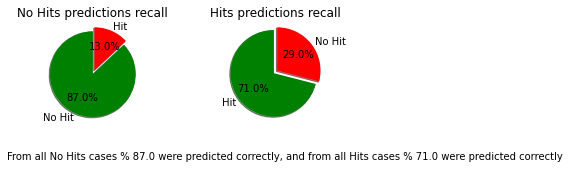

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.22</span> below the baseline.

Hit Precision is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     136998    20502
Yes Hit      2728     6772



<h3>Running: ADASYN splitting in size 8 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.63
Cohen's kappa coefficient: 0.33


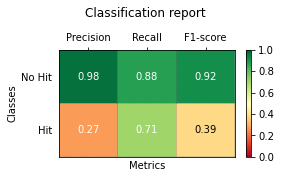

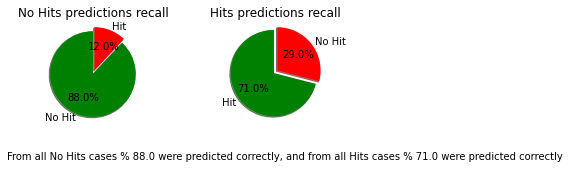

Cohen's kappa coefficient is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.68</span> below the baseline.

Hit Precision is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     131459    18541
Yes Hit      2779     6721



<h3>Running: ADASYN splitting in size 9 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.27
Cohen's kappa coefficient: 0.35


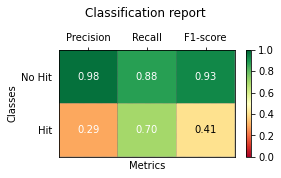

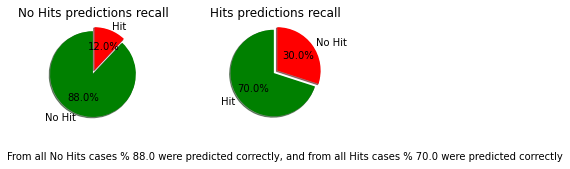

Cohen's kappa coefficient is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.04</span> below the baseline.

Hit Precision is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126021    16479
Yes Hit      2876     6624



<h3>Running: ADASYN splitting in size 10 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.65
Cohen's kappa coefficient: 0.37


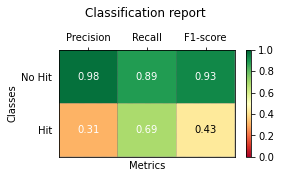

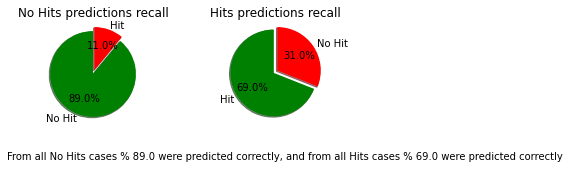

Cohen's kappa coefficient is <span style="color:green"> +0.37</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.66</span> below the baseline.

Hit Precision is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     120064    14936
Yes Hit      2903     6597



<h3>Running: ADASYN splitting in size 11 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.94
Cohen's kappa coefficient: 0.38


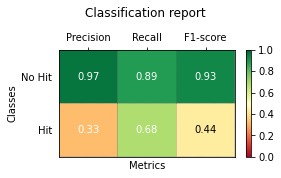

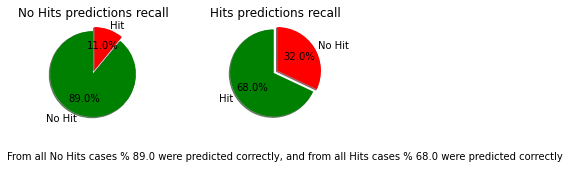

Cohen's kappa coefficient is <span style="color:green"> +0.38</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.37</span> below the baseline.

Hit Precision is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     114038    13462
Yes Hit      3060     6440



In [59]:
resampler = ADASYN()
positives = 15

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.93
Cohen's kappa coefficient: 0.10


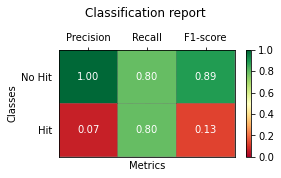

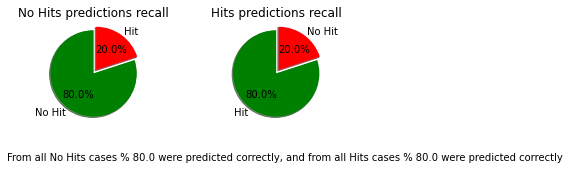

Cohen's kappa coefficient is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.38</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     146278    36722
Yes Hit       707     2793



<h3>Running: SMOTE splitting in size 3 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.25
Cohen's kappa coefficient: 0.12


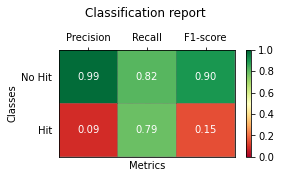

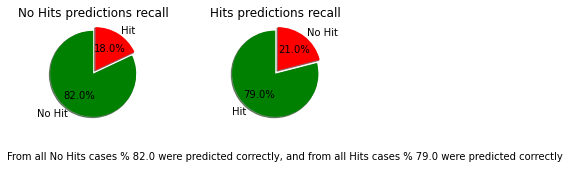

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.06</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.79</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     139538    29962
Yes Hit       737     2763



<h3>Running: SMOTE splitting in size 4 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.70
Cohen's kappa coefficient: 0.14


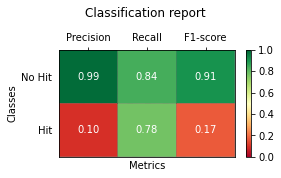

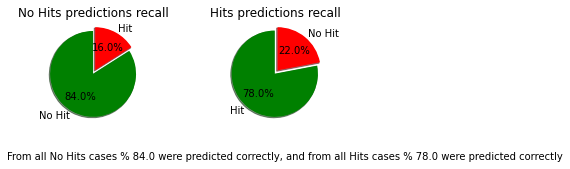

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.61</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     130789    25211
Yes Hit       780     2720



<h3>Running: SMOTE splitting in size 5 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.71
Cohen's kappa coefficient: 0.16


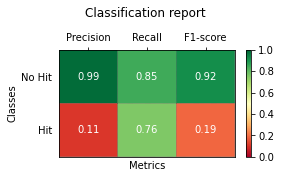

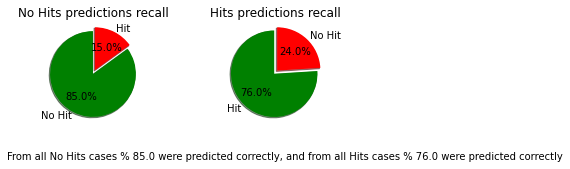

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.6</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     121011    21489
Yes Hit       838     2662



<h3>Running: SMOTE splitting in size 6 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.86
Cohen's kappa coefficient: 0.18


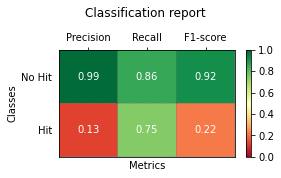

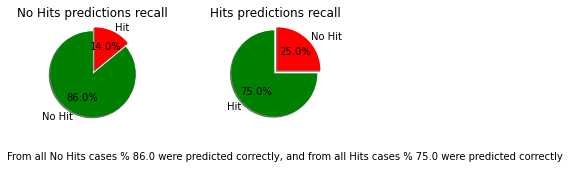

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.45</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     111152    17848
Yes Hit       891     2609



<h3>Running: SMOTE splitting in size 7 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.31
Cohen's kappa coefficient: 0.20


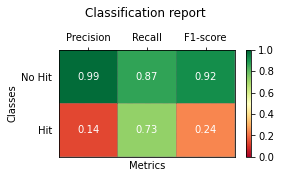

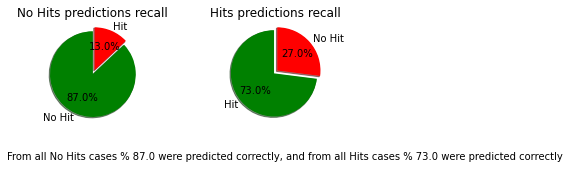

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.0</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     100156    15344
Yes Hit       952     2548



<h3>Running: SMOTE splitting in size 8 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.95
Cohen's kappa coefficient: 0.23


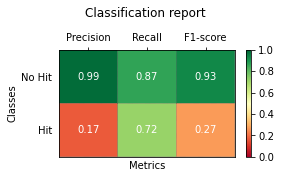

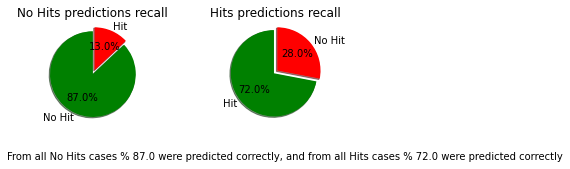

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.36</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      89203    12797
Yes Hit       972     2528



<h3>Running: SMOTE splitting in size 9 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.37
Cohen's kappa coefficient: 0.26


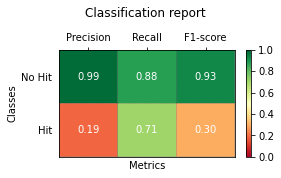

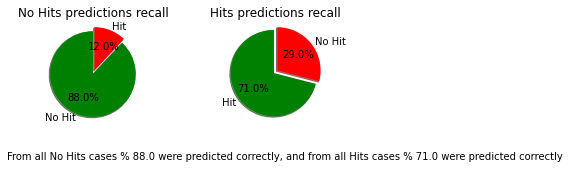

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.94</span> below the baseline.

Hit Precision is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      77882    10618
Yes Hit      1003     2497



<h3>Running: SMOTE splitting in size 10 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.61
Cohen's kappa coefficient: 0.29


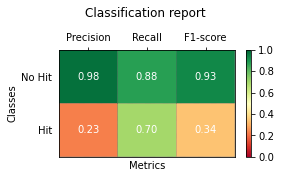

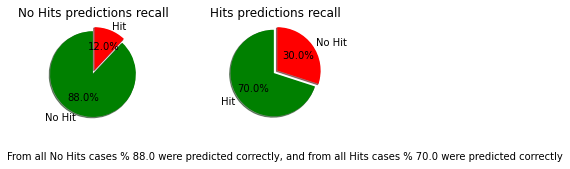

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.7</span> below the baseline.

Hit Precision is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      66338     8662
Yes Hit      1066     2434



<h3>Running: SMOTE splitting in size 11 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.02
Cohen's kappa coefficient: 0.34


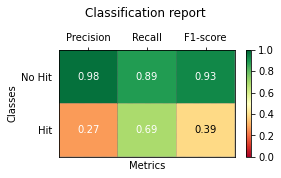

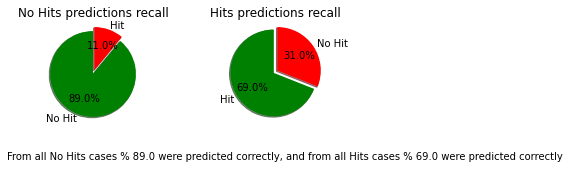

Cohen's kappa coefficient is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.29</span> below the baseline.

Hit Precision is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      54785     6715
Yes Hit      1071     2429



In [60]:
resampler = SMOTE()
positives = 27
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.68
Cohen's kappa coefficient: 0.10


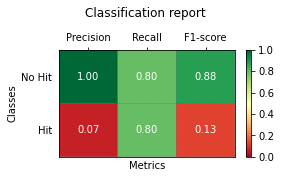

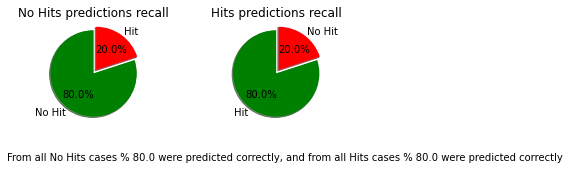

Cohen's kappa coefficient is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.63</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145784    37216
Yes Hit       689     2811



<h3>Running: ADASYN splitting in size 3 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.29
Cohen's kappa coefficient: 0.12


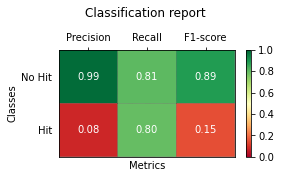

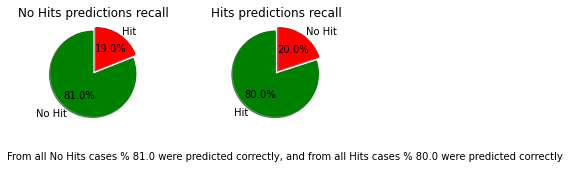

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.02</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     137845    31655
Yes Hit       706     2794



<h3>Running: ADASYN splitting in size 4 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.10
Cohen's kappa coefficient: 0.14


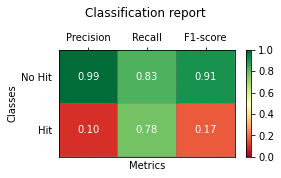

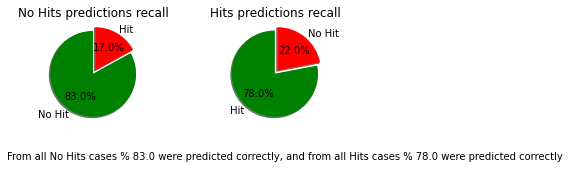

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.21</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     129802    26198
Yes Hit       758     2742



<h3>Running: ADASYN splitting in size 5 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.08
Cohen's kappa coefficient: 0.16


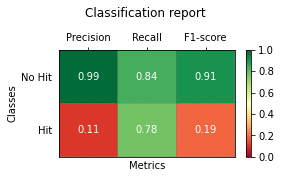

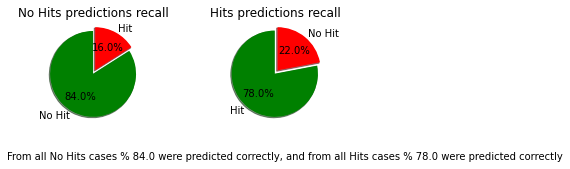

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.23</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     120036    22464
Yes Hit       779     2721



<h3>Running: ADASYN splitting in size 6 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.24
Cohen's kappa coefficient: 0.18


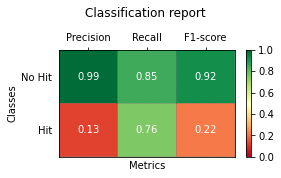

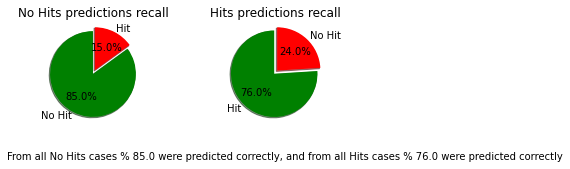

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.07</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     110287    18713
Yes Hit       850     2650



<h3>Running: ADASYN splitting in size 7 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.50
Cohen's kappa coefficient: 0.21


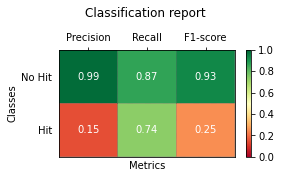

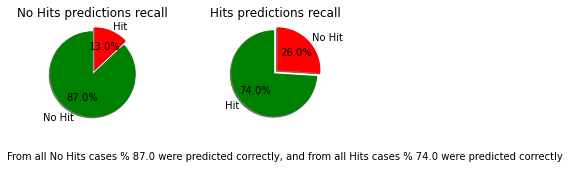

Cohen's kappa coefficient is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.81</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     100348    15152
Yes Hit       916     2584



<h3>Running: ADASYN splitting in size 8 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.55
Cohen's kappa coefficient: 0.22


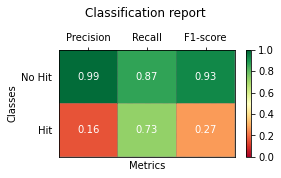

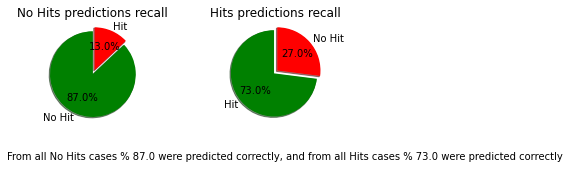

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.76</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      88775    13225
Yes Hit       961     2539



<h3>Running: ADASYN splitting in size 9 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.51
Cohen's kappa coefficient: 0.26


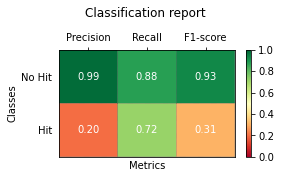

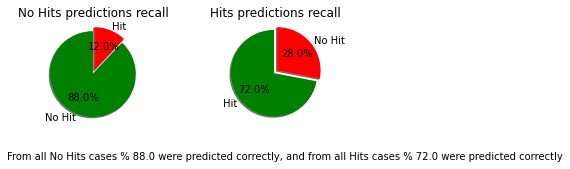

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.8</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      77982    10518
Yes Hit       974     2526



<h3>Running: ADASYN splitting in size 10 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.73
Cohen's kappa coefficient: 0.30


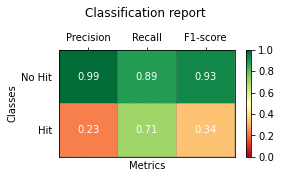

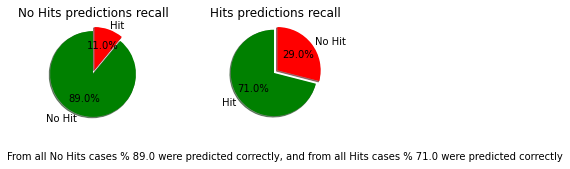

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.58</span> below the baseline.

Hit Precision is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      66384     8616
Yes Hit      1016     2484



<h3>Running: ADASYN splitting in size 11 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.59
Cohen's kappa coefficient: 0.32


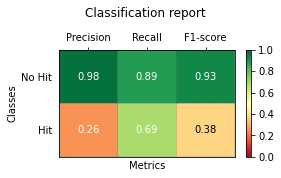

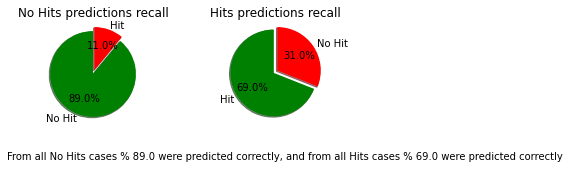

Cohen's kappa coefficient is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.72</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      54507     6993
Yes Hit      1075     2425



In [61]:
resampler = ADASYN()
positives = 27

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.27
Cohen's kappa coefficient: 0.09


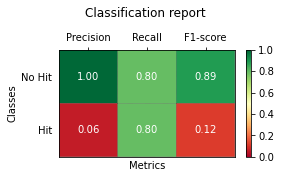

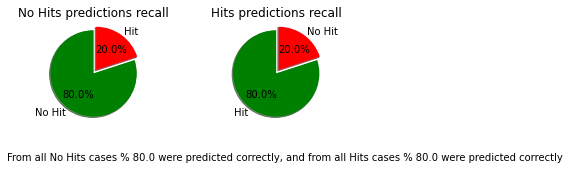

Cohen's kappa coefficient is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.04</span> below the baseline.

Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     146095    35905
Yes Hit       598     2402



<h3>Running: SMOTE splitting in size 3 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.30
Cohen's kappa coefficient: 0.11


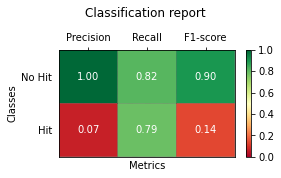

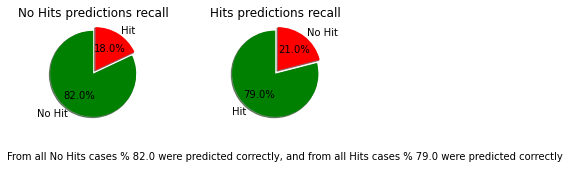

Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.01</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.79</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     138365    29635
Yes Hit       637     2363



<h3>Running: SMOTE splitting in size 4 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.73
Cohen's kappa coefficient: 0.12


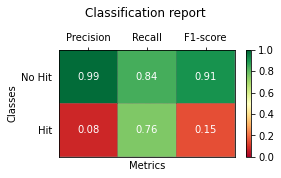

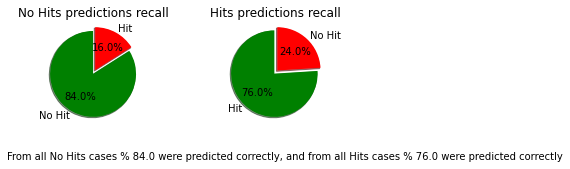

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.58</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     129189    24811
Yes Hit       732     2268



<h3>Running: SMOTE splitting in size 5 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.71
Cohen's kappa coefficient: 0.14


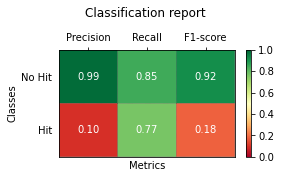

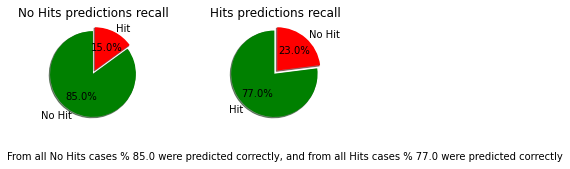

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.6</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     118817    21183
Yes Hit       685     2315



<h3>Running: SMOTE splitting in size 6 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.69
Cohen's kappa coefficient: 0.16


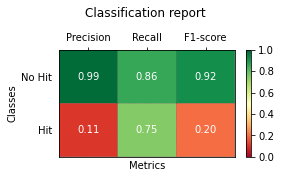

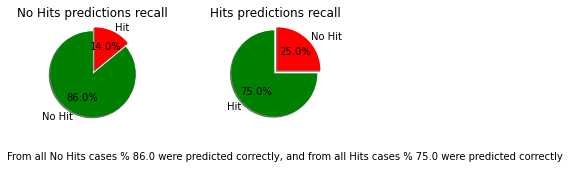

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.62</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     108283    17717
Yes Hit       749     2251



<h3>Running: SMOTE splitting in size 7 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.49
Cohen's kappa coefficient: 0.19


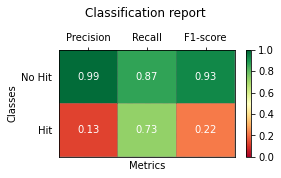

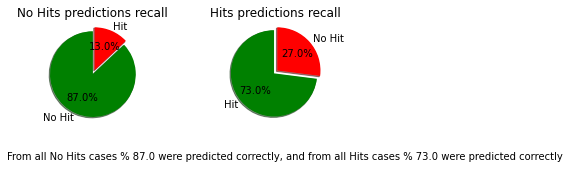

Cohen's kappa coefficient is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.82</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      97261    14739
Yes Hit       800     2200



<h3>Running: SMOTE splitting in size 8 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.94
Cohen's kappa coefficient: 0.21


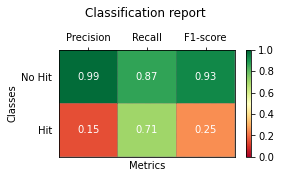

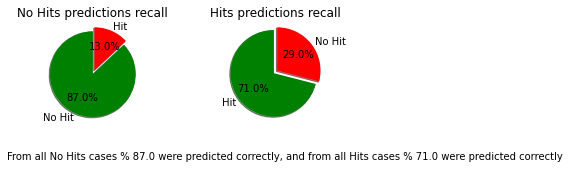

Cohen's kappa coefficient is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.37</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      85681    12319
Yes Hit       872     2128



<h3>Running: SMOTE splitting in size 9 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.22
Cohen's kappa coefficient: 0.24


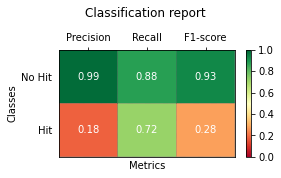

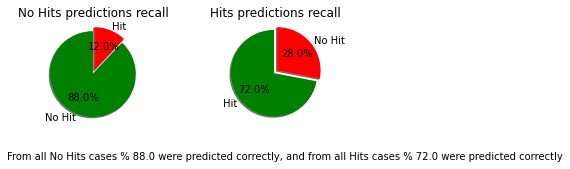

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -5.09</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      73729    10271
Yes Hit       844     2156



In [27]:
resampler = SMOTE()
positives = 28
for i in range(2,10):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)